In [1]:
import os
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.9'
import jax
import jax.numpy as jnp
from jax import random,  vmap, jit
from jax import config
# from jax.ops import index_update, index
from jax import lax
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from tqdm.auto import trange, tqdm
import time

from scipy.interpolate import griddata
from scipy.sparse import csr_matrix

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
# plt.rcParams.update({'font.size': 5})

config.update("jax_enable_x64", True)

initial_mean=jnp.array([[0,0,0]])

from A4M42 import PKS
from aux import gen_initX

rngseed1=245
rng_key1=random.PRNGKey(rngseed1)

rngseed2=255
rng_key2=random.PRNGKey(rngseed2)

ModelM0=80
pos=jnp.array([[0,0,0]])
T=2e-2
dt=0.1e-4
eps=1e-4
def Vfunc(X):
    Vx=jnp.zeros((3))
    return Vx

In [2]:
from scipy.sparse import diags, linalg, csc_matrix, csr_matrix

# Parameters
k = 0.1
mu = 1
chi = 1
epsilon = 1e-4
# Parameters
N = 500000
r = np.linspace(0, 20, N+2) # Spatial grid
dr = r[1] - r[0]  # Spatial step size

Nt = int(T/dt)  # Number of iterations
rho_supp=np.where(r<=1, 1, 0)
rho0=rho_supp/np.sum(rho_supp * 4*np.pi* r **2 *dr) * 80

results_file = '1D_rad_results.npz'


compute = True
if os.path.exists(results_file):
    try:
        loaded_data = np.load(results_file)
        params_match = True
        params_match &= np.allclose(loaded_data['rho0'], rho0)
        params_match &= loaded_data['N'] == N
        params_match &= loaded_data['Nt'] == Nt
        params_match &= np.isclose(loaded_data['dt'], dt)
        params_match &= np.isclose(loaded_data['dr'], dr)
        params_match &= np.isclose(loaded_data['mu'], mu)
        params_match &= np.isclose(loaded_data['chi'], chi)
        params_match &= np.isclose(loaded_data['eps'], eps)
        params_match &= np.isclose(loaded_data['k'], k)
        params_match &= np.allclose(loaded_data['r'], r)
        
        if params_match:
            rho = loaded_data['rho'].copy()
            c = loaded_data['c'].copy()
            compute = False
            print("Results loaded from file.")
    except Exception as e:
        print(f"Error loading file: {e}. Recomputing...")
        compute = True
else:
    print("No results file found. Starting computation...")

if compute:
    print("Computing results...")
    rho=np.copy(rho0)
    c=np.zeros(N+2)
    # Create the matrix A
    C_diag = np.zeros(N)
    C_upper = np.zeros(N-1)
    C_lower = np.zeros(N-1)
    rho_diag = np.zeros(N)
    rho_upper = np.zeros(N-1)
    rho_lower = np.zeros(N-1)
    b_rho = np.zeros(N)
    b_c = np.zeros(N)
    
    
    for it in range(Nt):
        
        rho_diag[0]= 1 + dt * mu / dr ** 2 + 2 * mu * dt / (r[1] * dr)
        rho_diag[0]+= -chi * dt * (c[2]-c[1]) / dr**2 + chi * dt * (c[2]-2*c[1]+c[0]) / dr ** 2 + 2*chi * dt * (c[2]-c[1]) / (r[1] * dr)
        rho_diag[1:N-1] = 1 + 2 * dt * mu / dr ** 2 + 2 * mu * dt / (r[2:N] * dr)
        rho_diag[1:N - 1] += - chi * dt * np.diff(c[2:N + 1]) / dr**2 + chi * dt * np.diff(np.diff(c[1:N + 1])) / dr ** 2 + 2 * chi * dt * np.diff(c[2:N + 1]) / (r[2:N] * dr)
        rho_diag[N - 1] = 1 + dt * mu / dr ** 2
        rho_diag[N - 1] += chi * dt * (c[N] - 2 * c[N - 1] + c[N - 2]) / dr ** 2 + 2 * chi * dt * (c[N] - c[N - 1]) / (r[N ] * dr)
        rho_upper = -dt * mu / dr ** 2 - 2*mu * dt / (r[1:N] * dr) + dt * chi * np.diff(c[1:N+1]) / dr ** 2
        rho_lower = -dt * mu / dr ** 2
        rho_matrix = diags([rho_upper, rho_diag, rho_lower], [1, 0, -1])
        rho_matrix = csc_matrix(rho_matrix)
    
        b_rho = rho[1:N+1]
        rho[1:N+1] = linalg.spsolve(rho_matrix, b_rho)
        rho[0] = rho[1]
        rho[-1] = rho[-2]
    
        C_diag[0]= 1 + dt/eps * (1/ dr ** 2 + 2 / (r[1] * dr)+k**2)
        C_diag[1:N-1] = 1 + dt/eps * (2/ dr ** 2 + 2 / (r[2:N] * dr)+k**2)
        C_diag[N-1] = 1 + dt / eps * (1 / dr ** 2 + k ** 2)
        C_upper = -dt/eps * (1/ dr ** 2 + 2 / (r[1:N] * dr))
        C_lower = -dt/eps * 1 / dr ** 2
        C = diags([C_upper, C_diag, C_lower], [1, 0, -1])
        C = csc_matrix(C)
    
        b_c = c[1:N+1] + dt * rho[1:N+1]/eps
        c[1:N+1] = linalg.spsolve(C, b_c)
        c[0]=c[1]
        c[-1]=c[-2]

    np.savez(results_file, 
                 rho=rho, c=c, r=r, 
                 N=N, Nt=Nt, dt=dt, dr=dr, 
                 mu=mu, chi=chi, eps=eps, k=k, 
                 rho0=rho0)
    print("Computation completed and results saved.")
maxrplt = 3

Results loaded from file.


--- Build time 0.0545198917388916 s ---
--- Total time 556.7442865371704 s ---


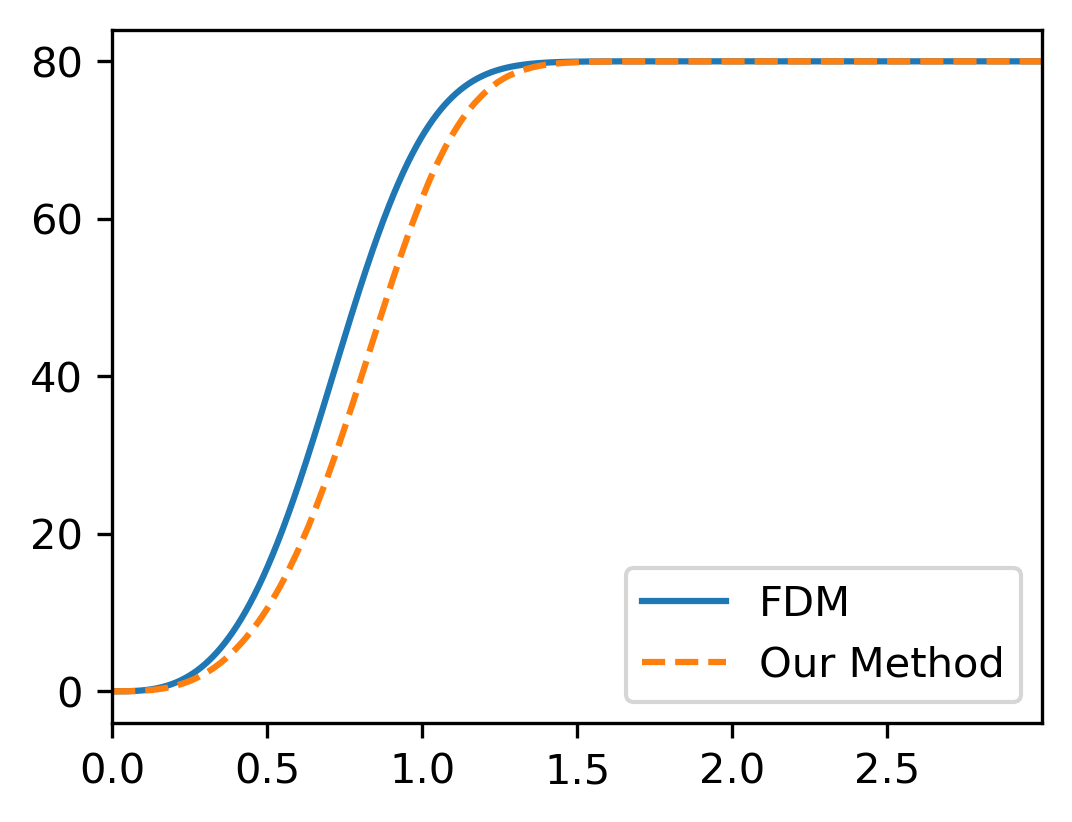

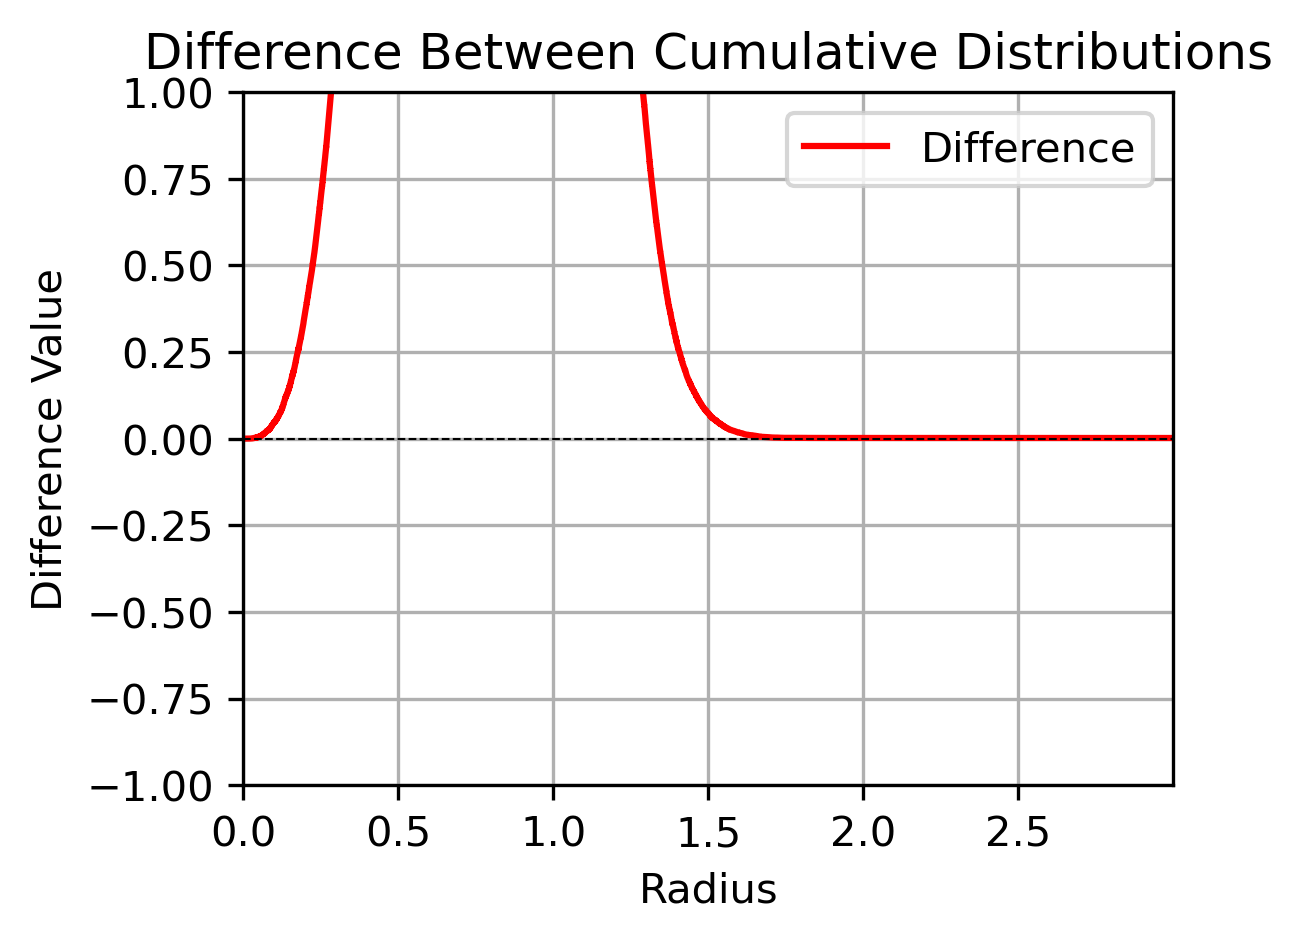

--- Build time 0.01562952995300293 s ---
--- Total time 556.4608566761017 s ---


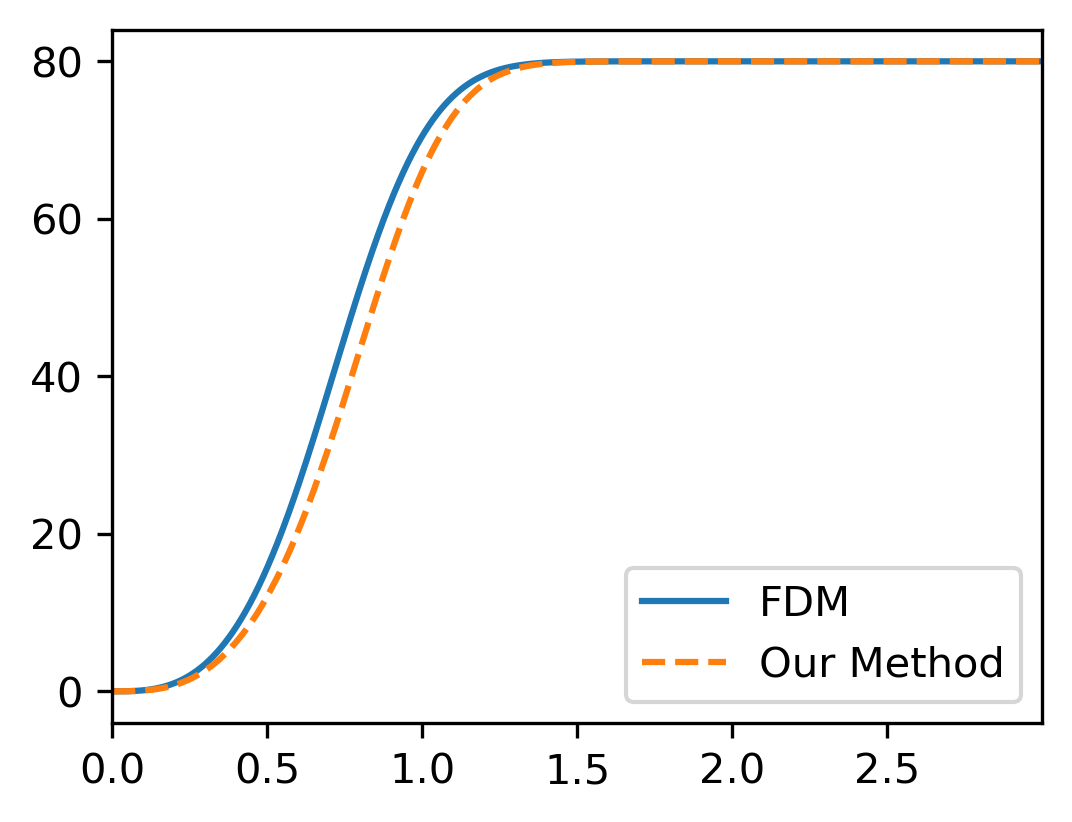

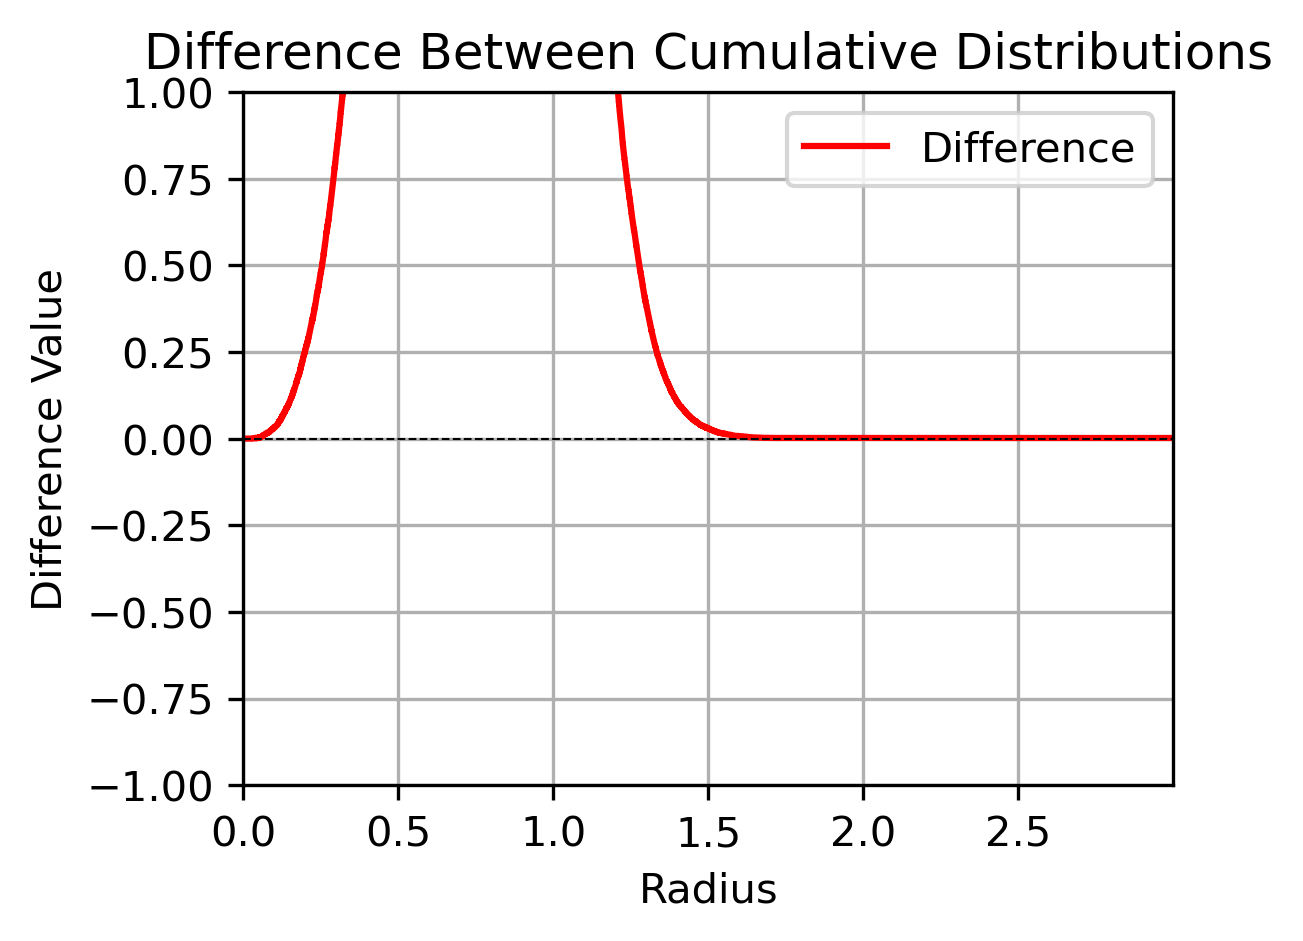

--- Build time 0.015635967254638672 s ---
--- Total time 554.5162816047668 s ---


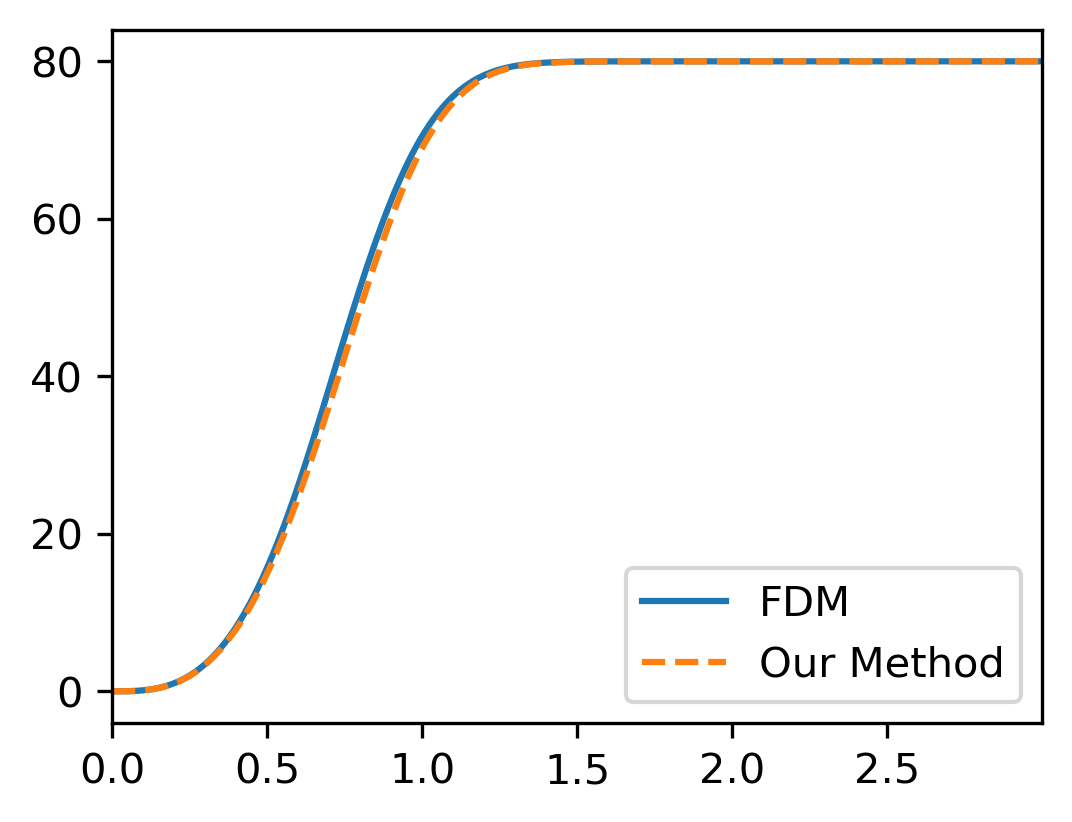

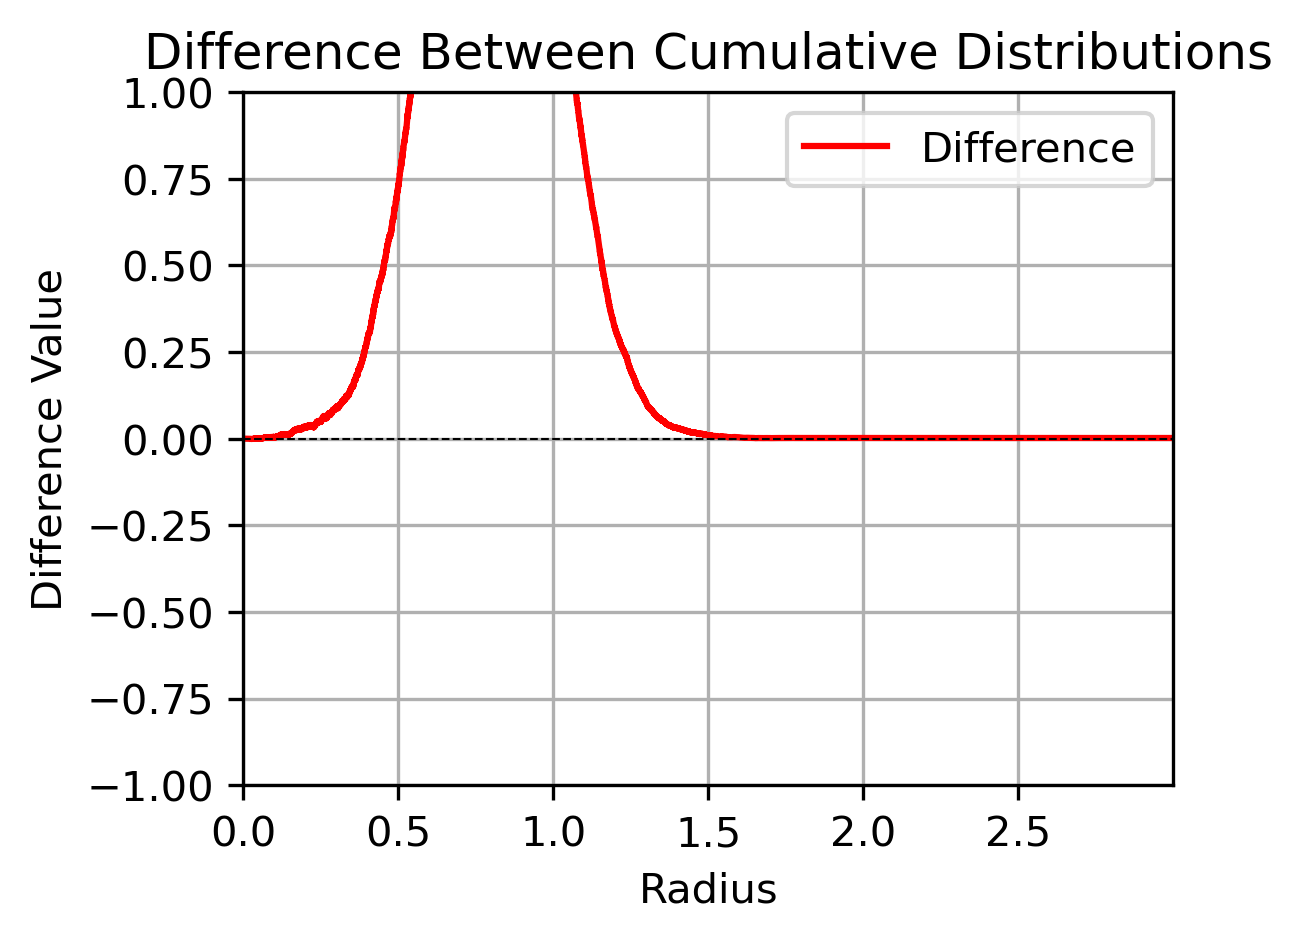

--- Build time 0.0 s ---
--- Total time 560.4595468044281 s ---


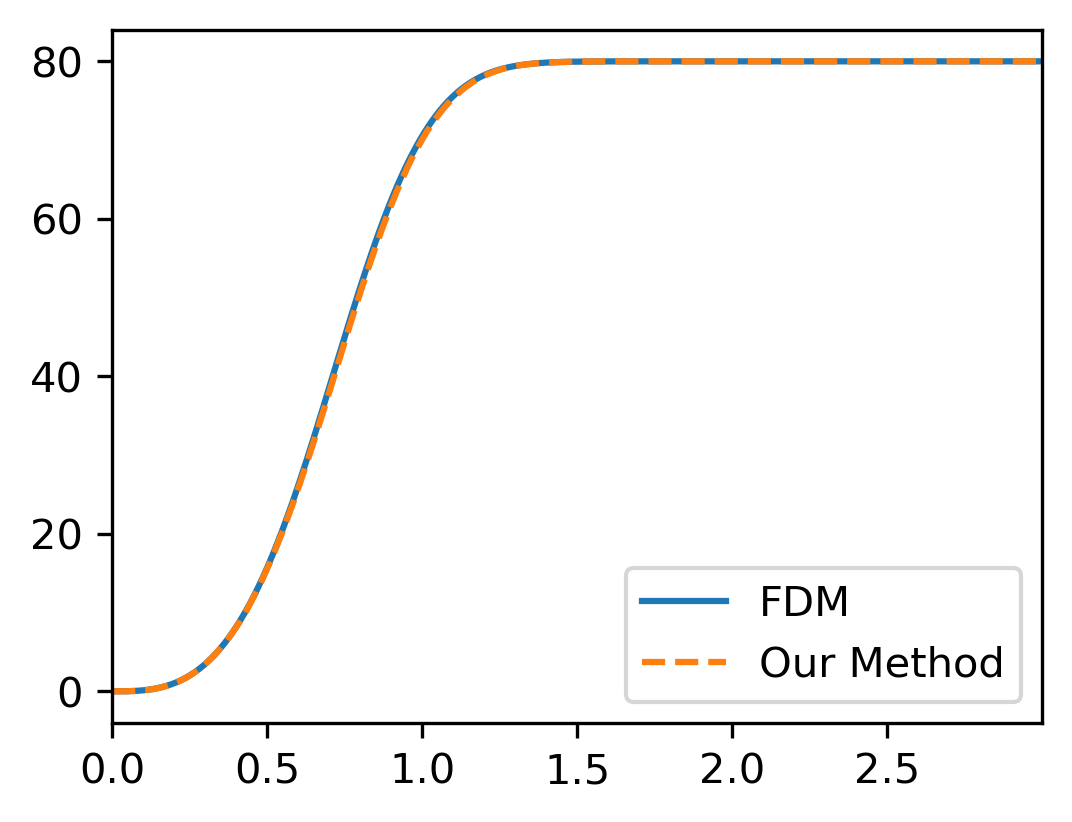

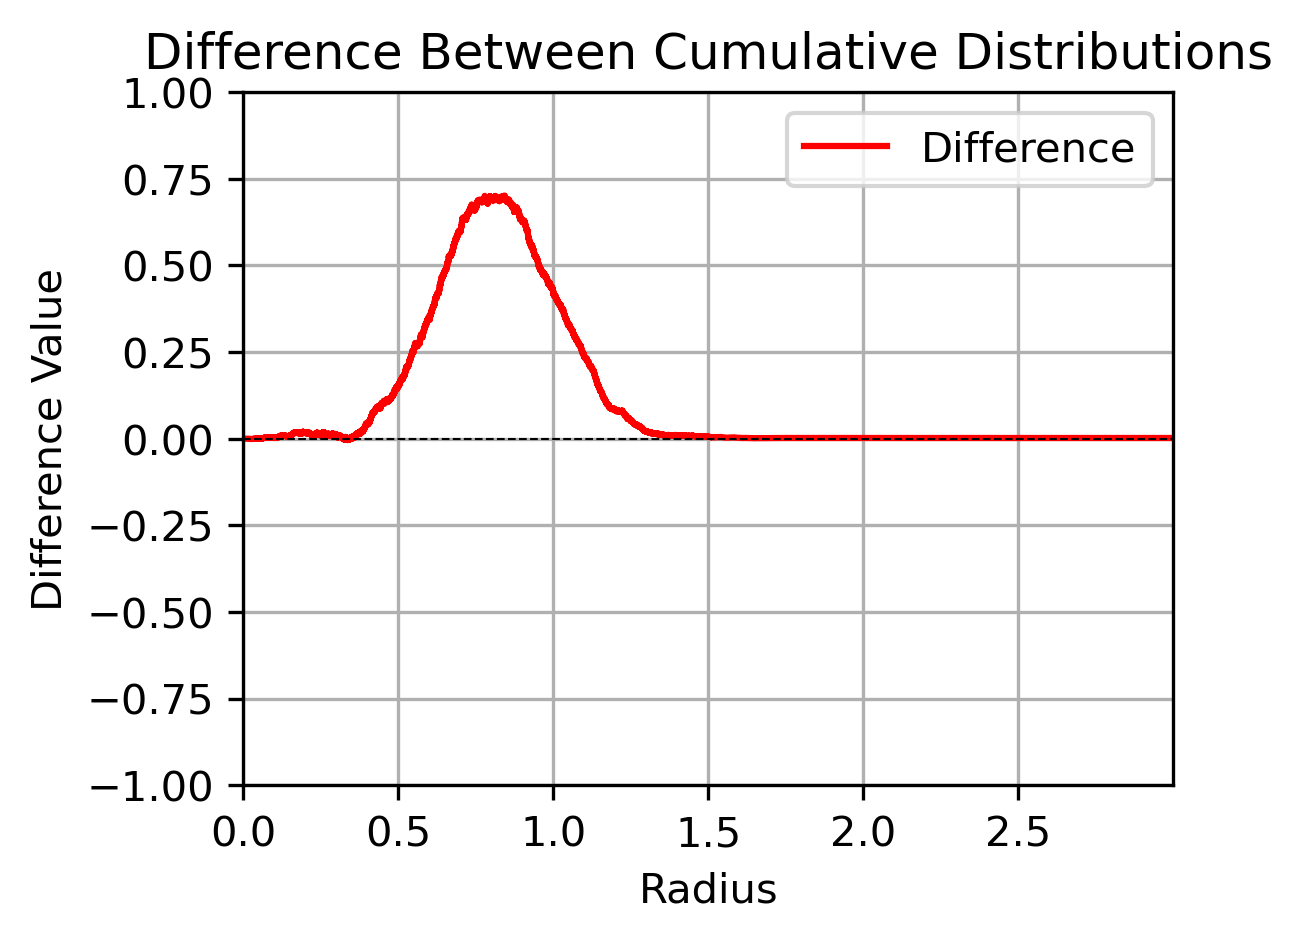

--- Build time 0.0 s ---
--- Total time 580.1263184547424 s ---


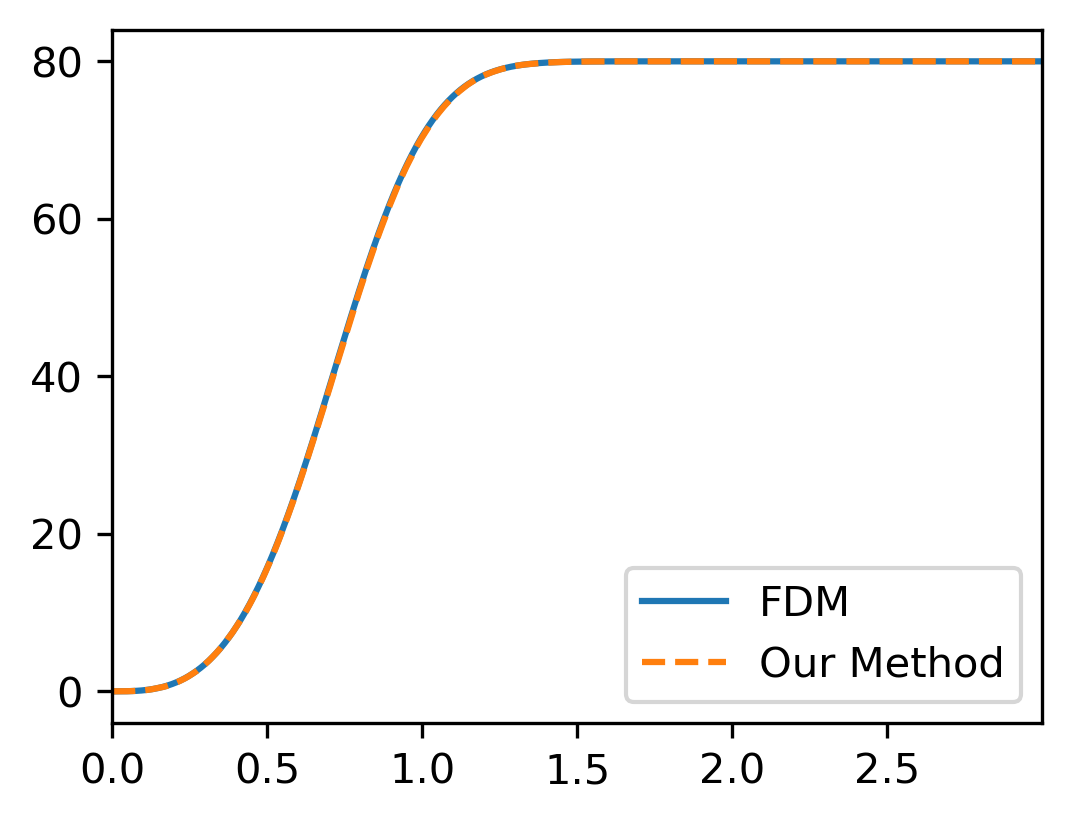

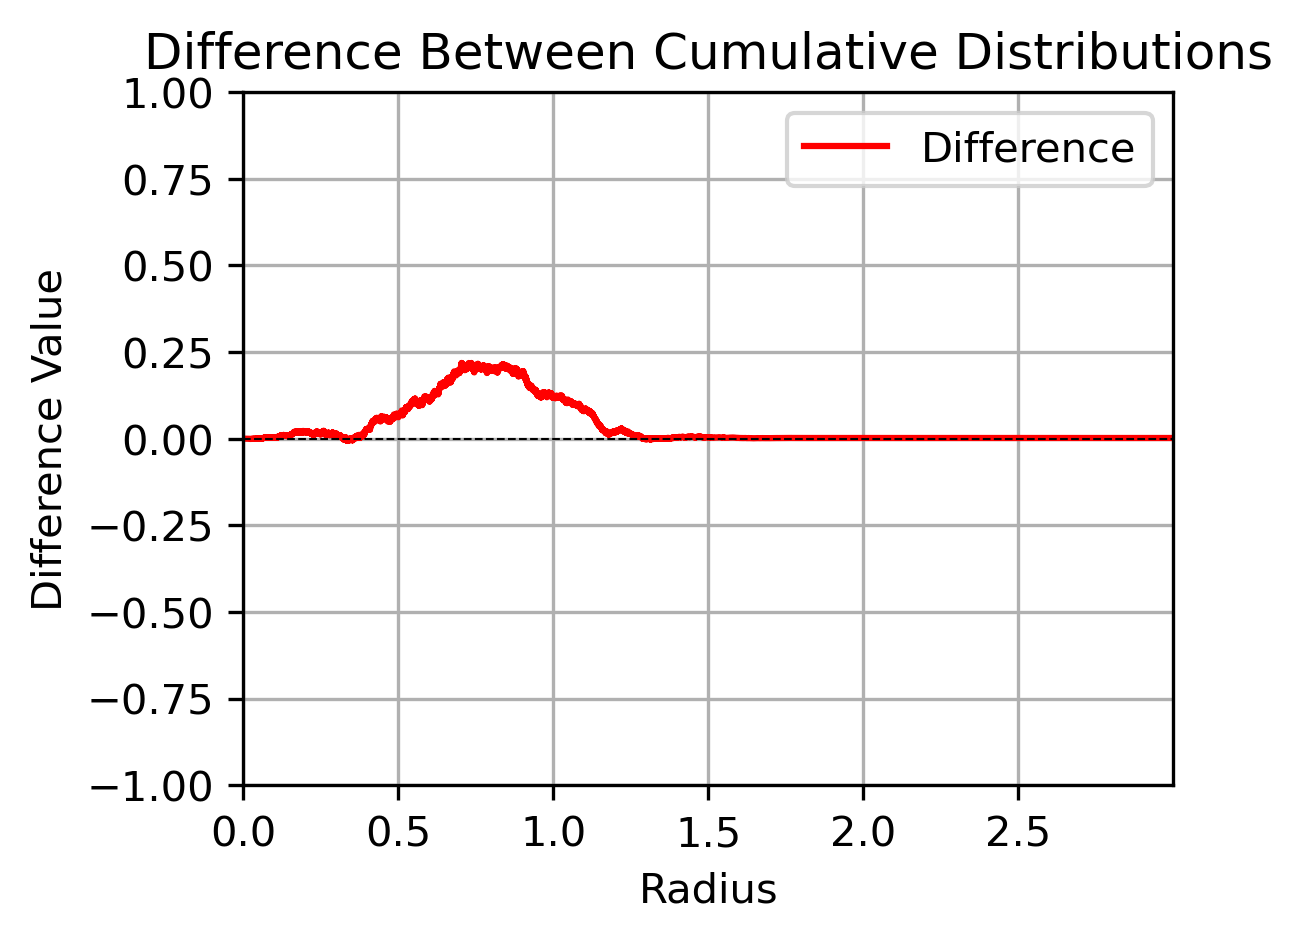

--- Build time 0.01455831527709961 s ---
--- Total time 751.1586349010468 s ---


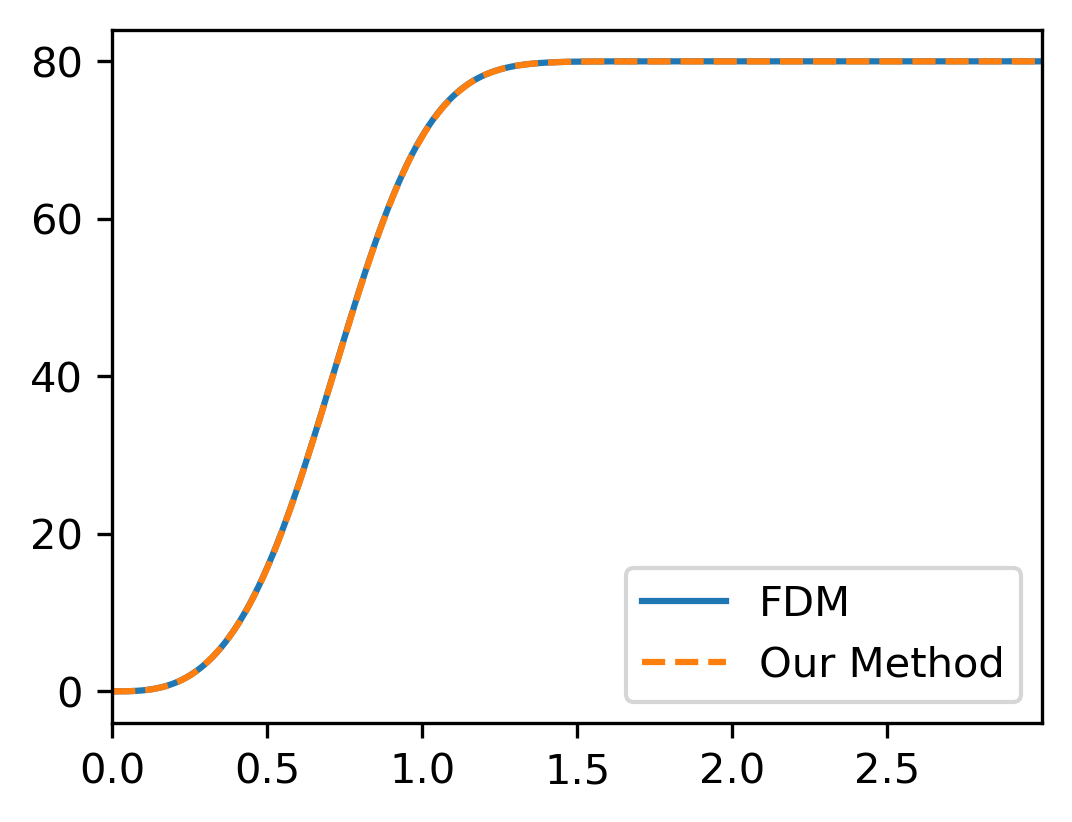

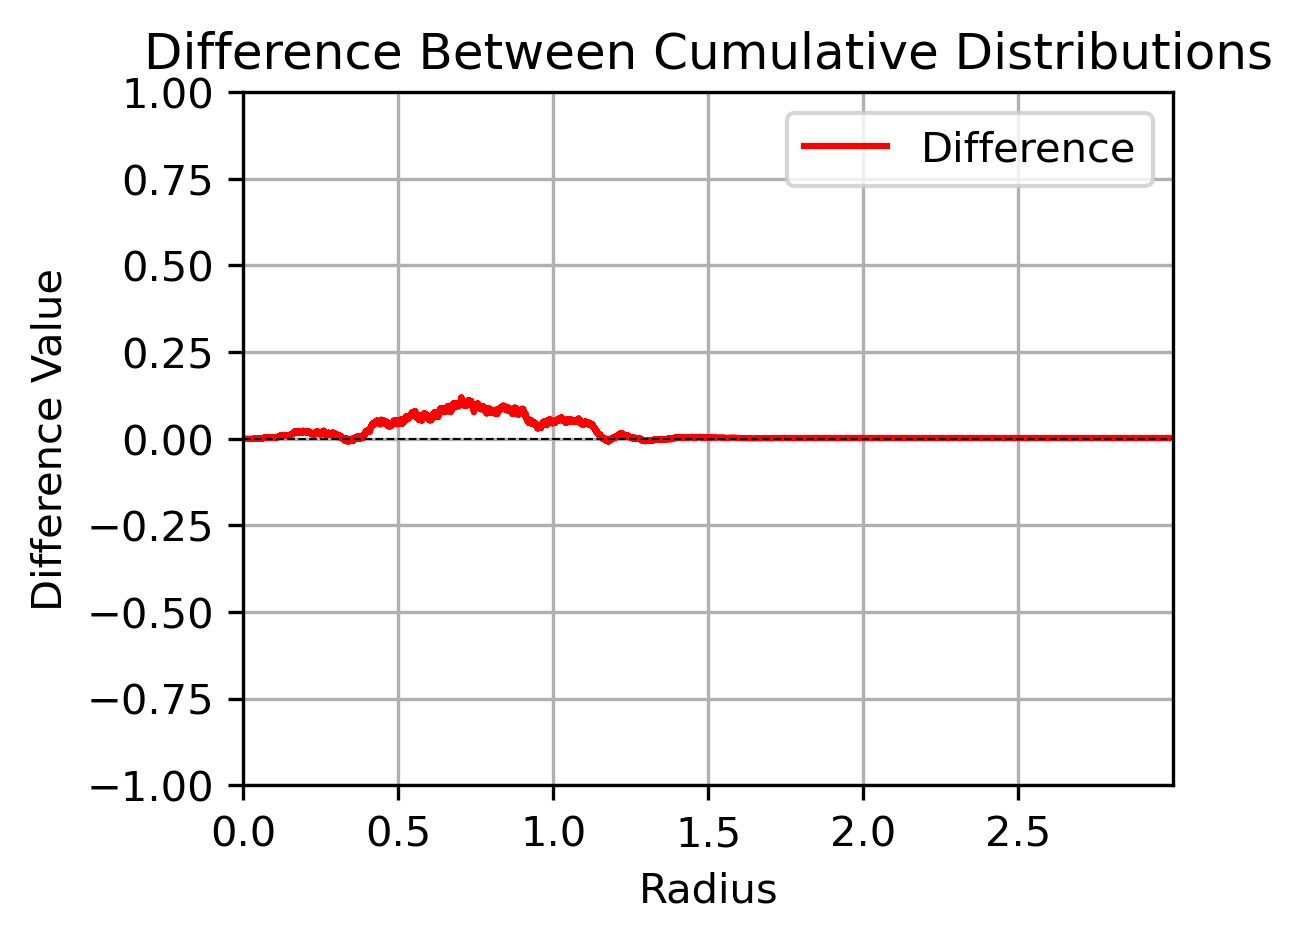

--- Build time 0.020434856414794922 s ---
--- Total time 2211.0556614398956 s ---


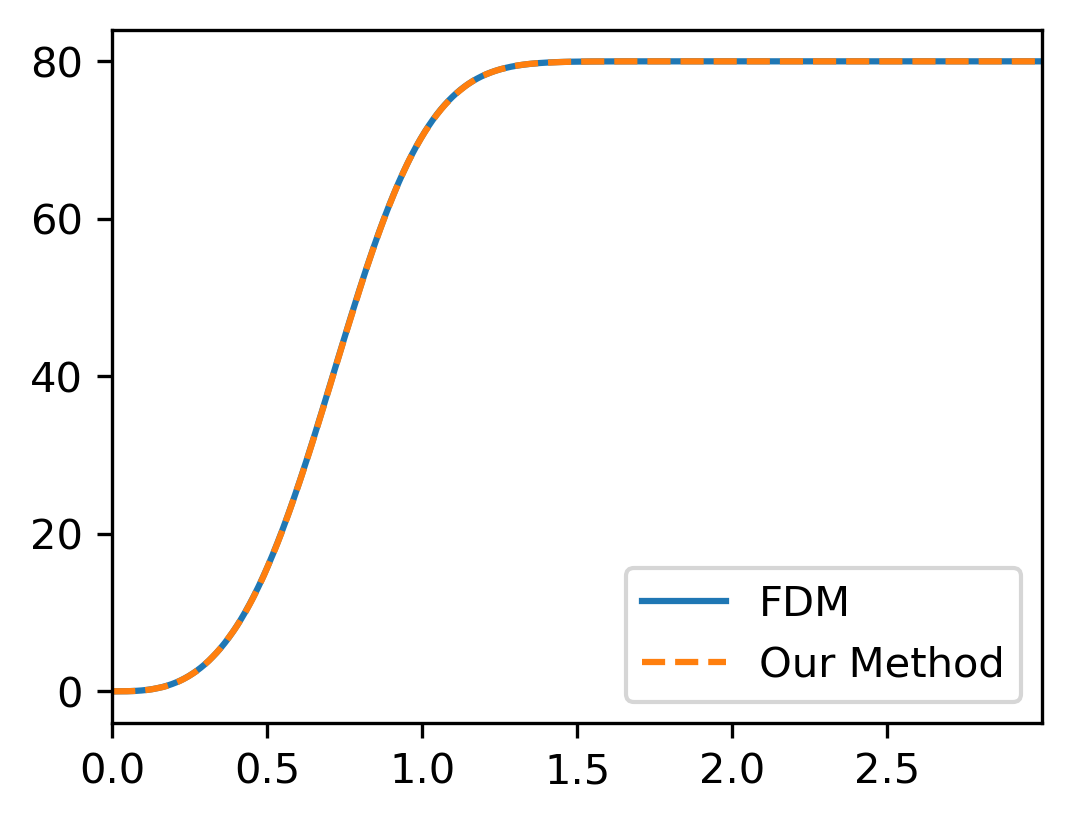

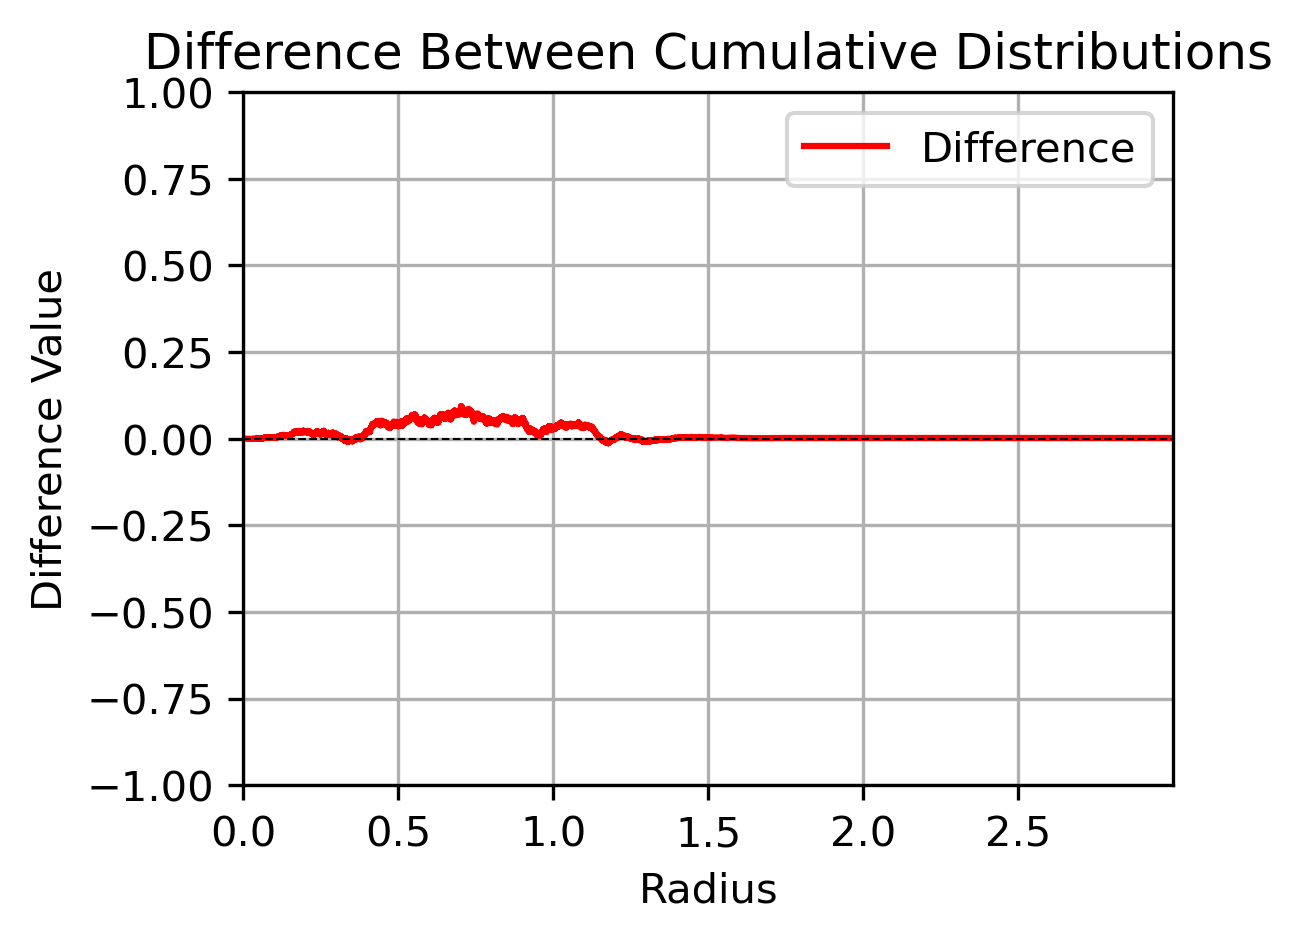

--- Build time 0.0 s ---
--- Total time 285.5566260814667 s ---


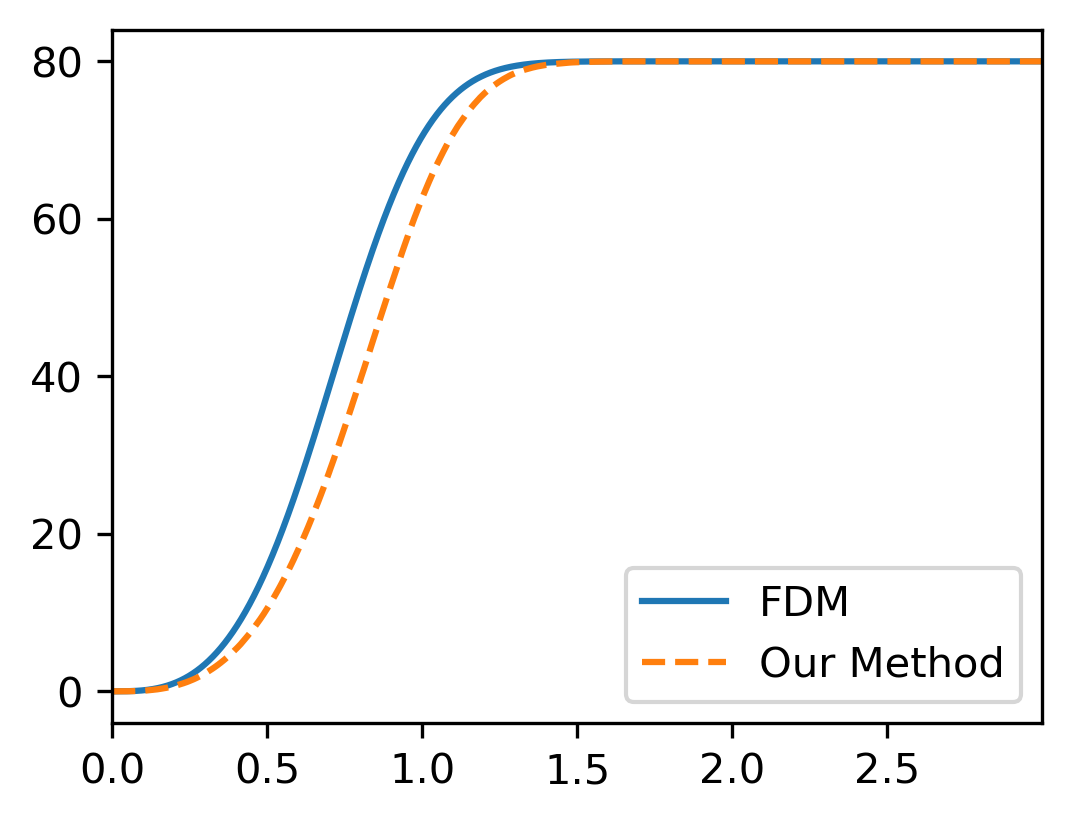

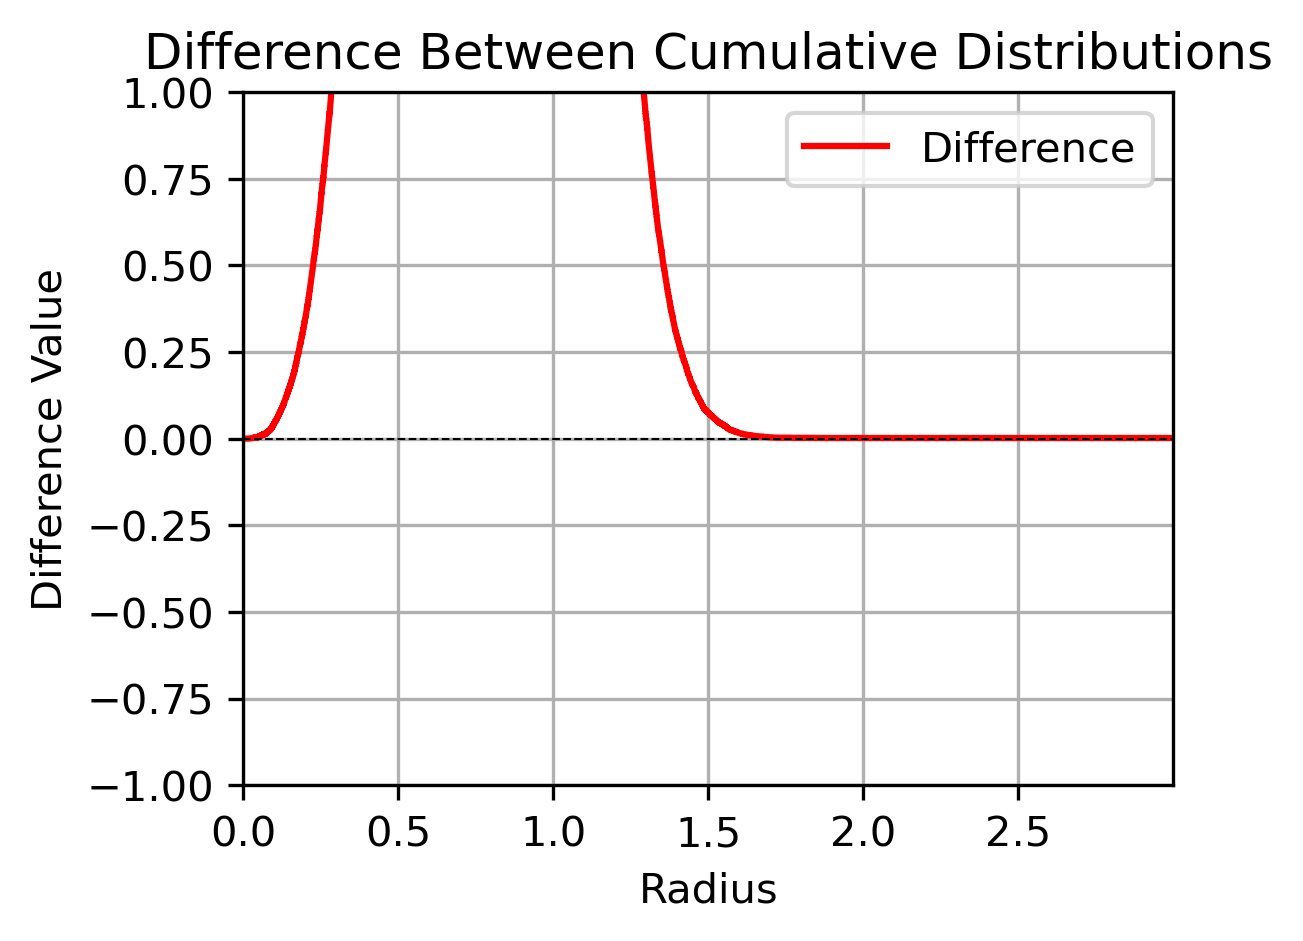

--- Build time 0.0 s ---
--- Total time 277.1405906677246 s ---


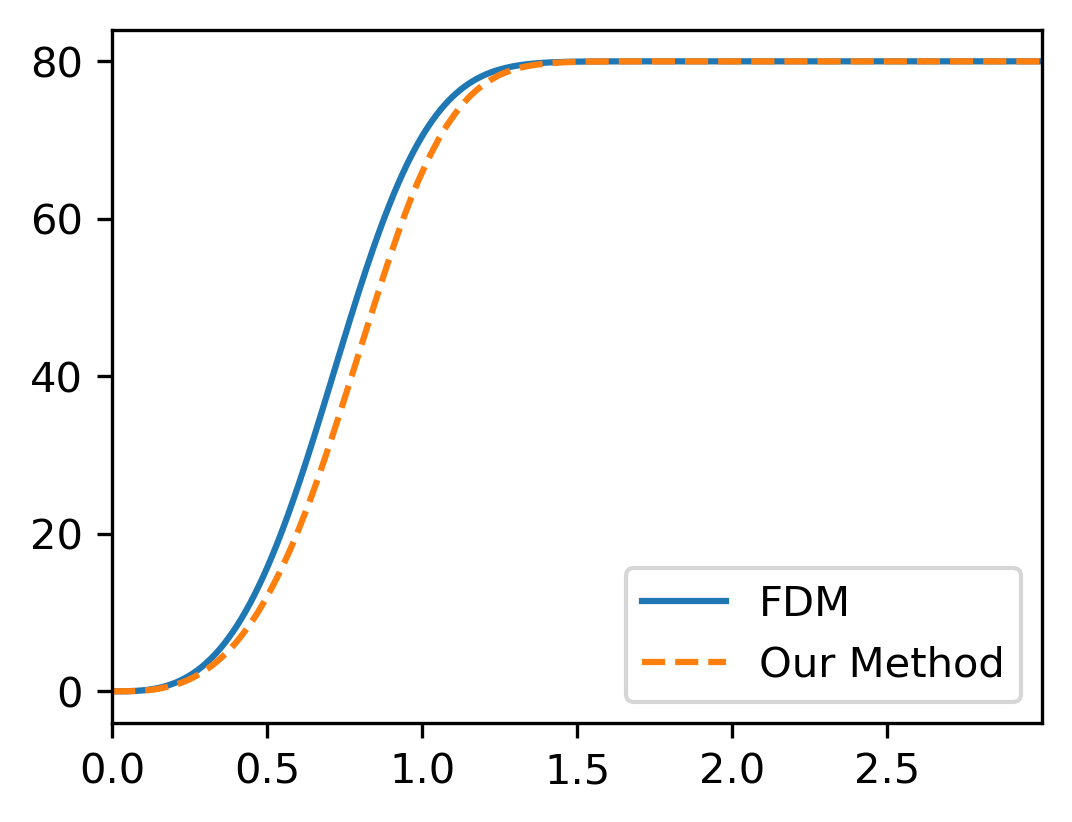

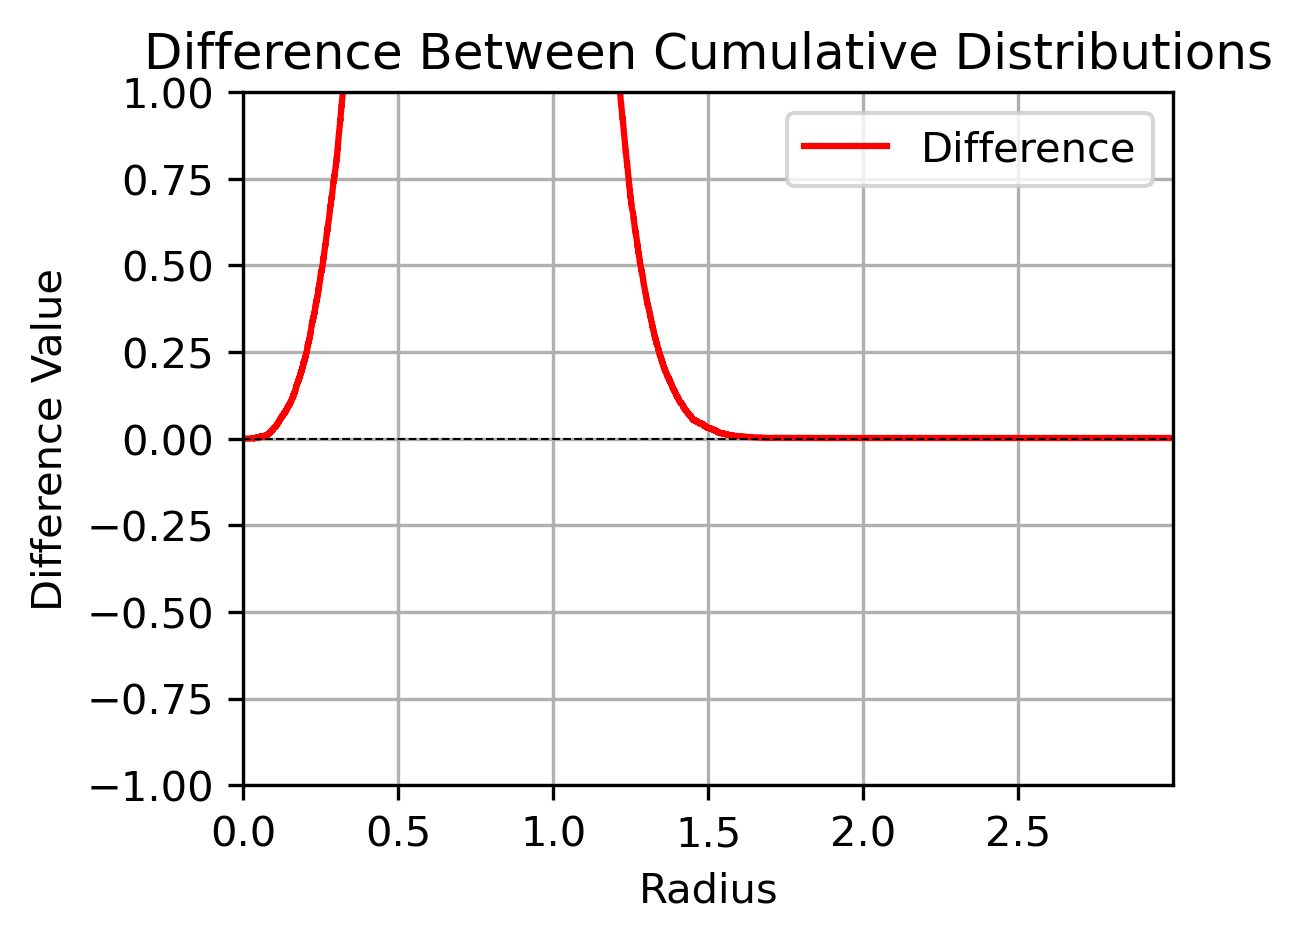

--- Build time 0.0 s ---
--- Total time 278.9035234451294 s ---


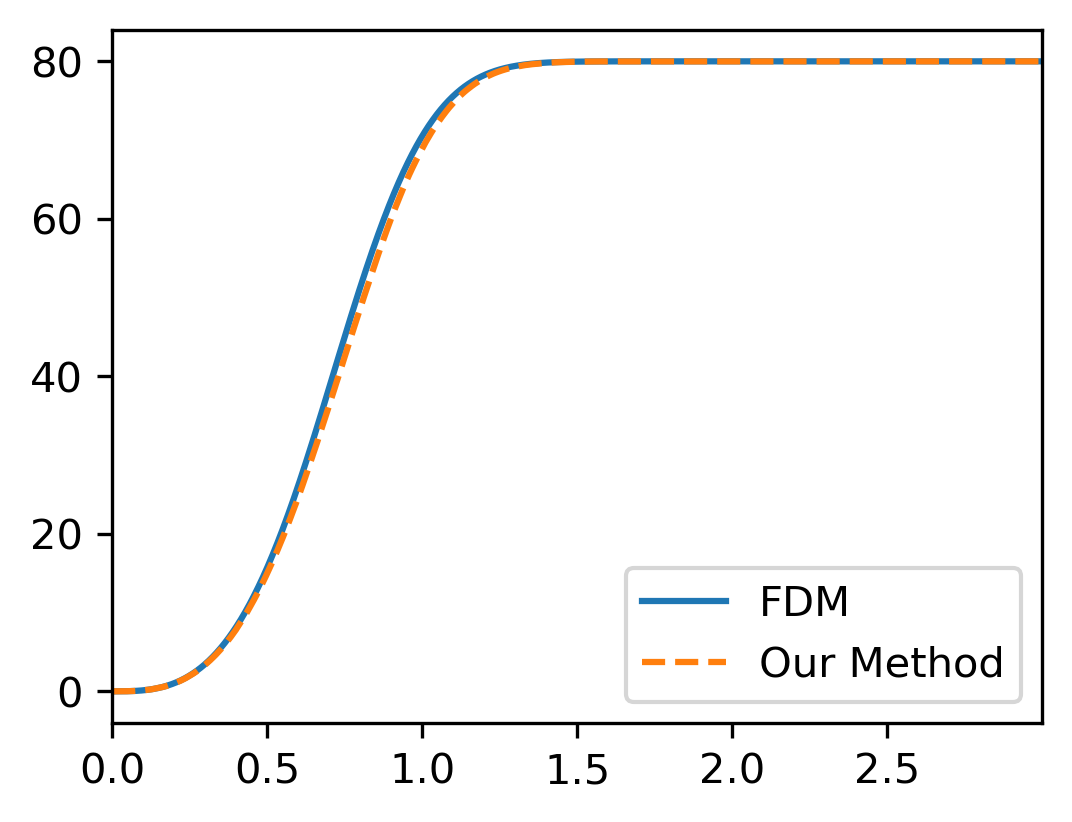

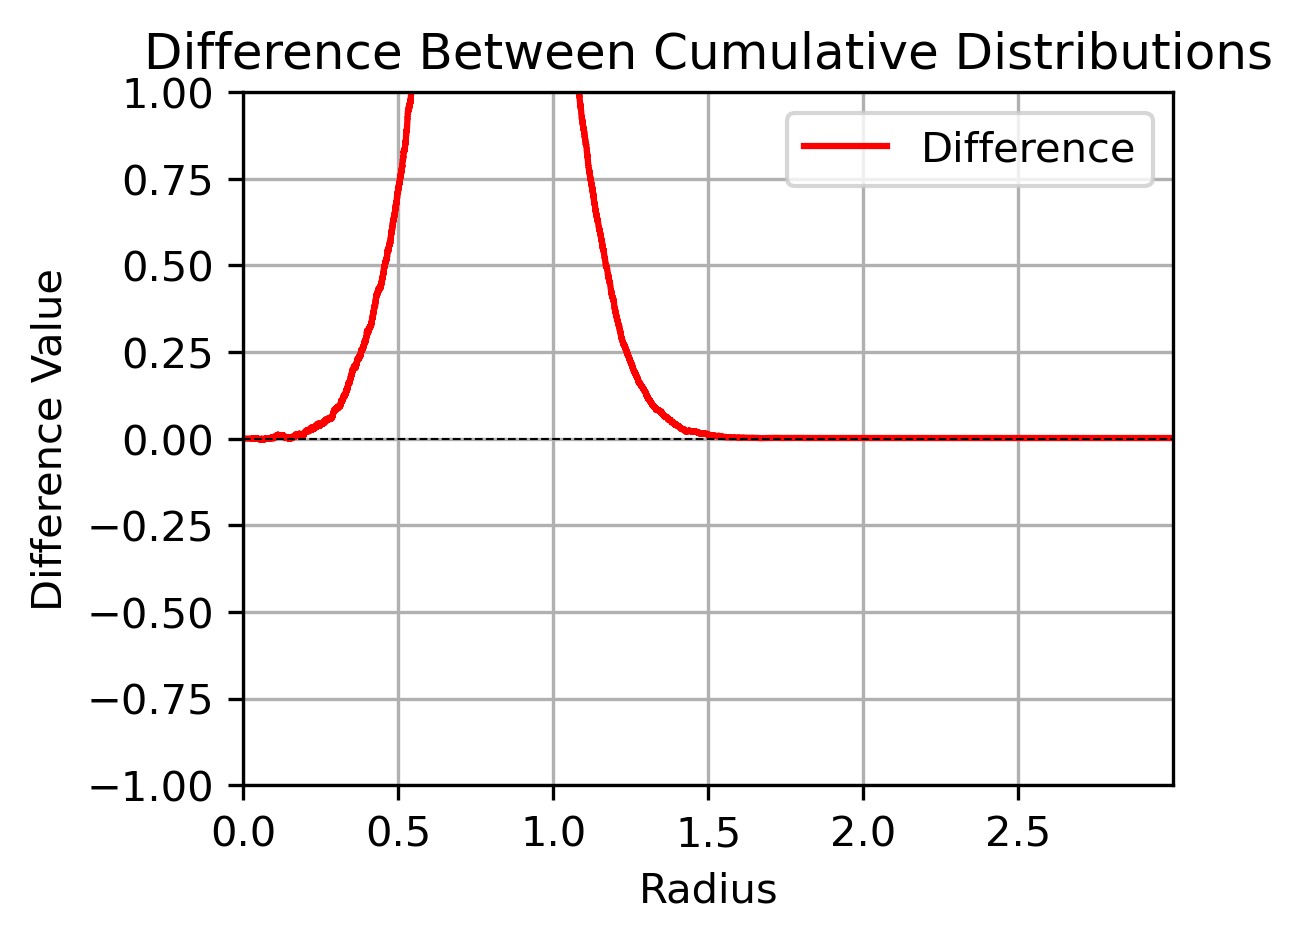

--- Build time 0.0 s ---
--- Total time 284.13813185691833 s ---


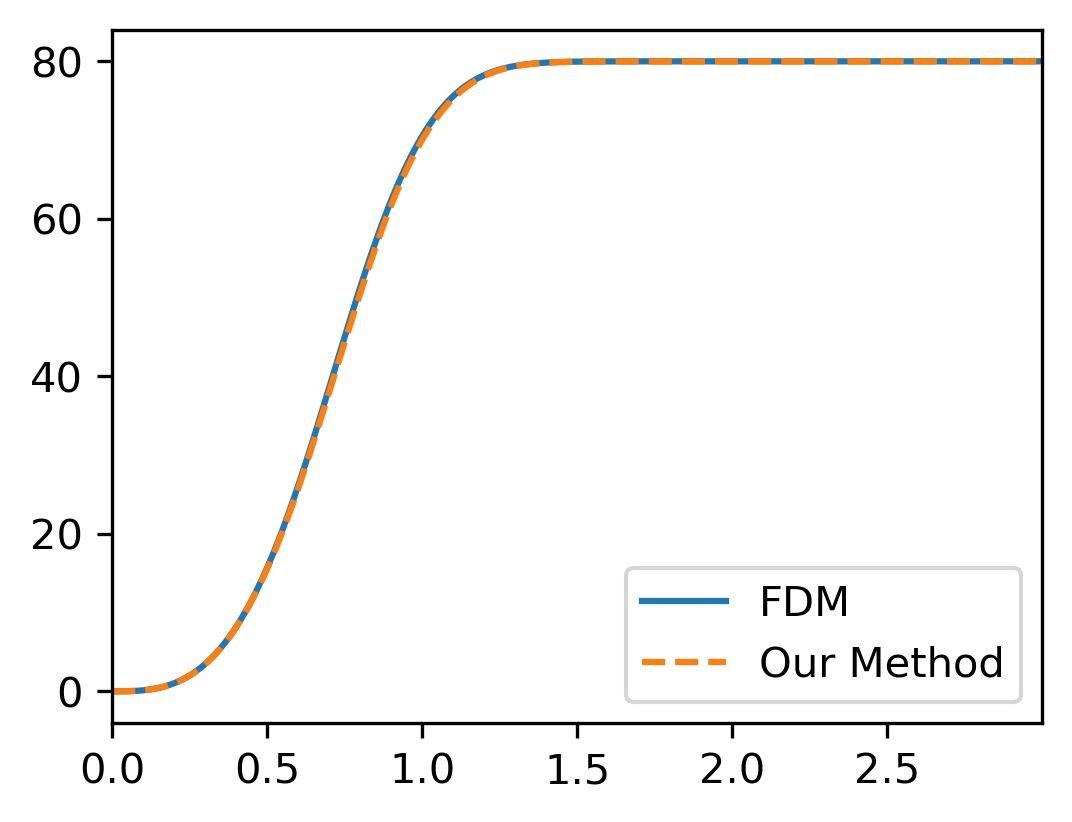

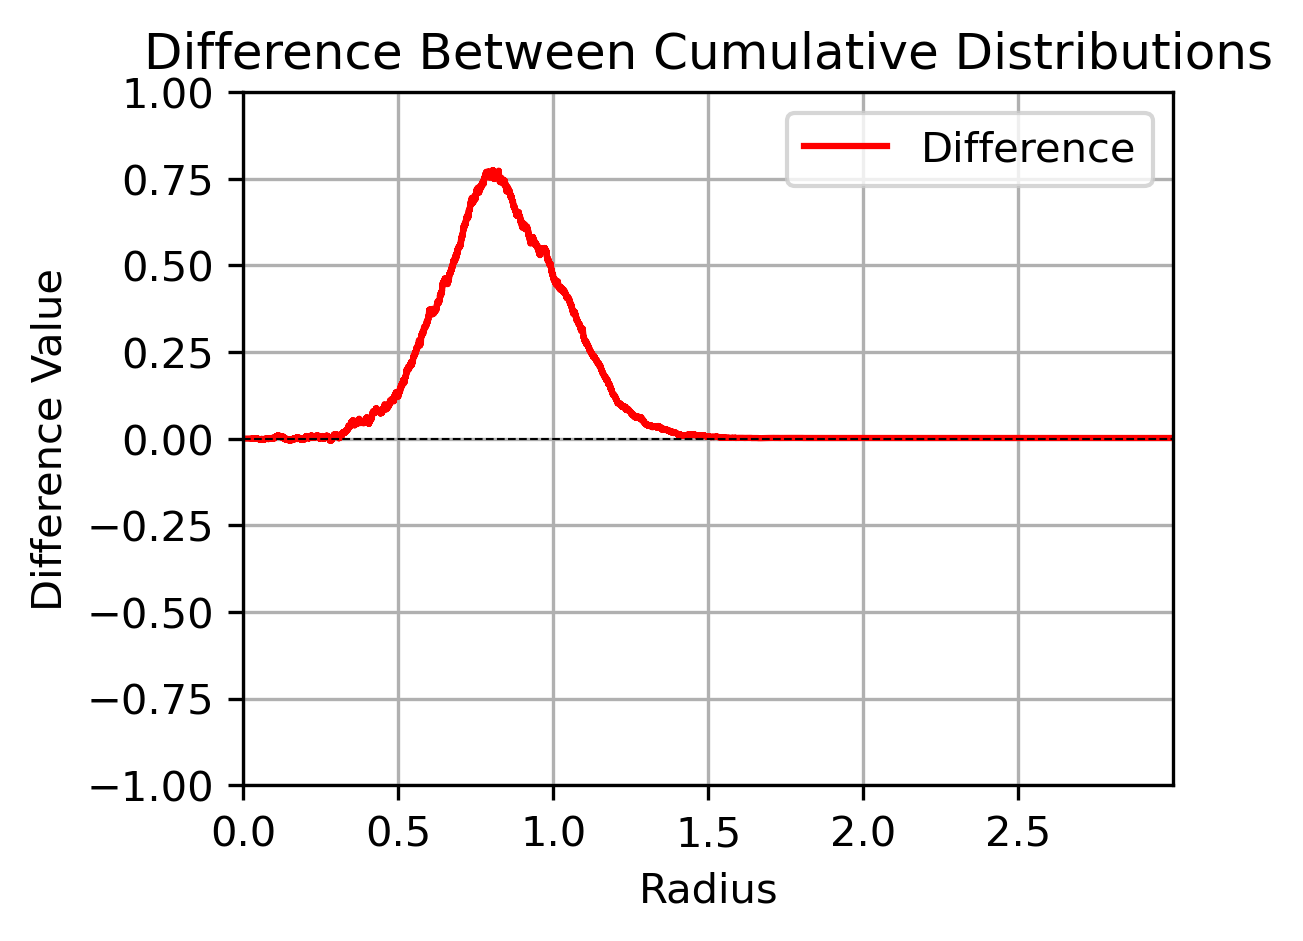

--- Build time 0.0 s ---
--- Total time 303.75467920303345 s ---


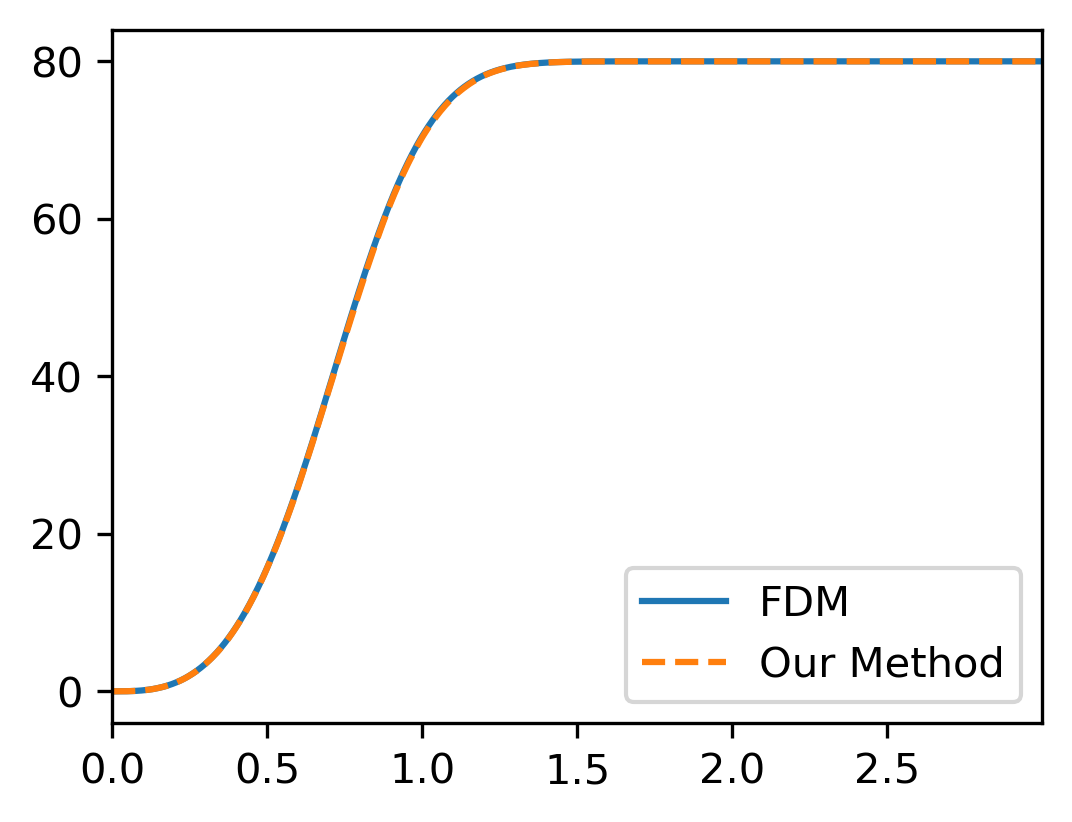

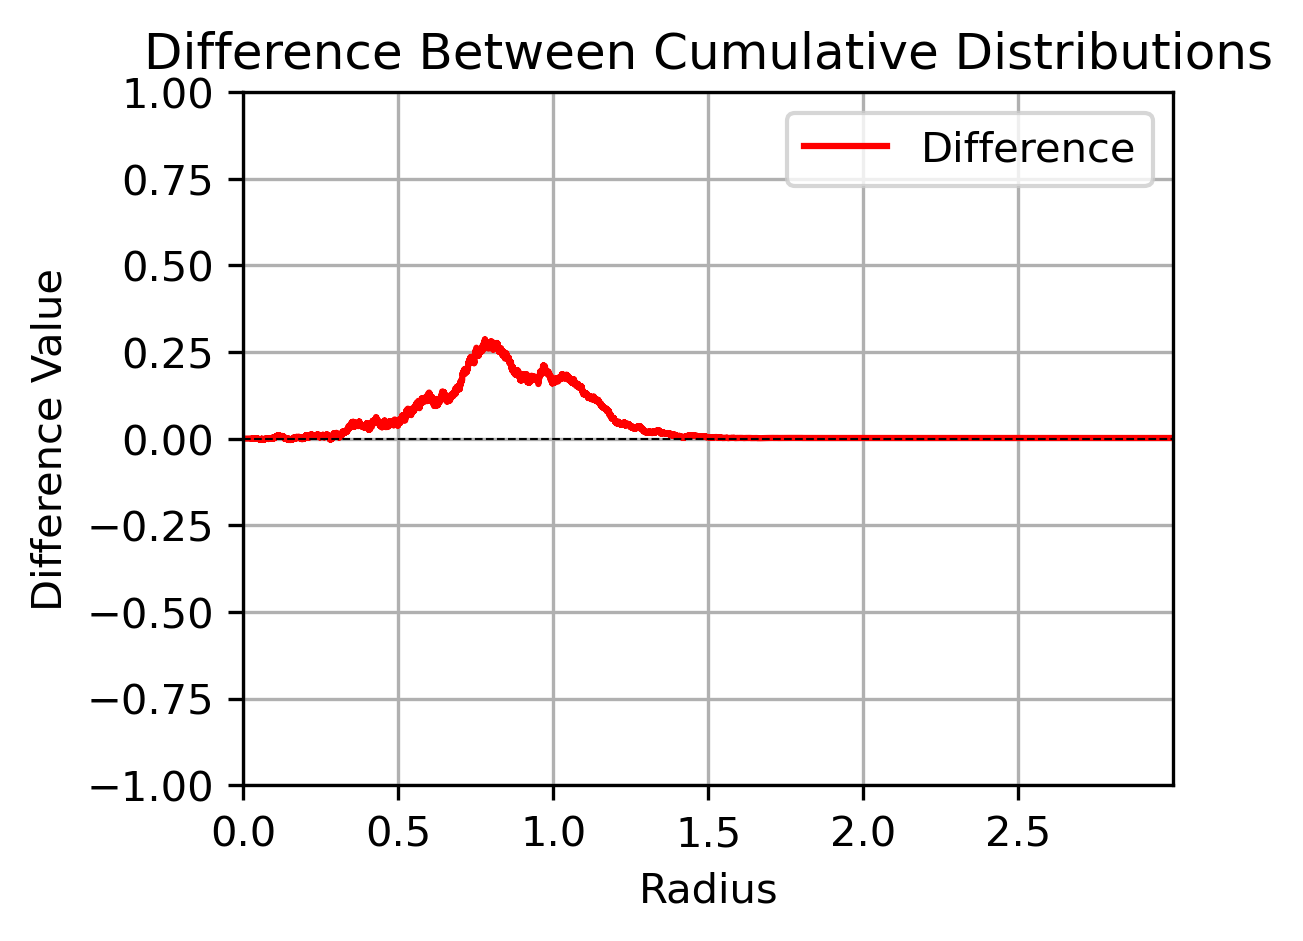

--- Build time 0.0 s ---
--- Total time 457.7646565437317 s ---


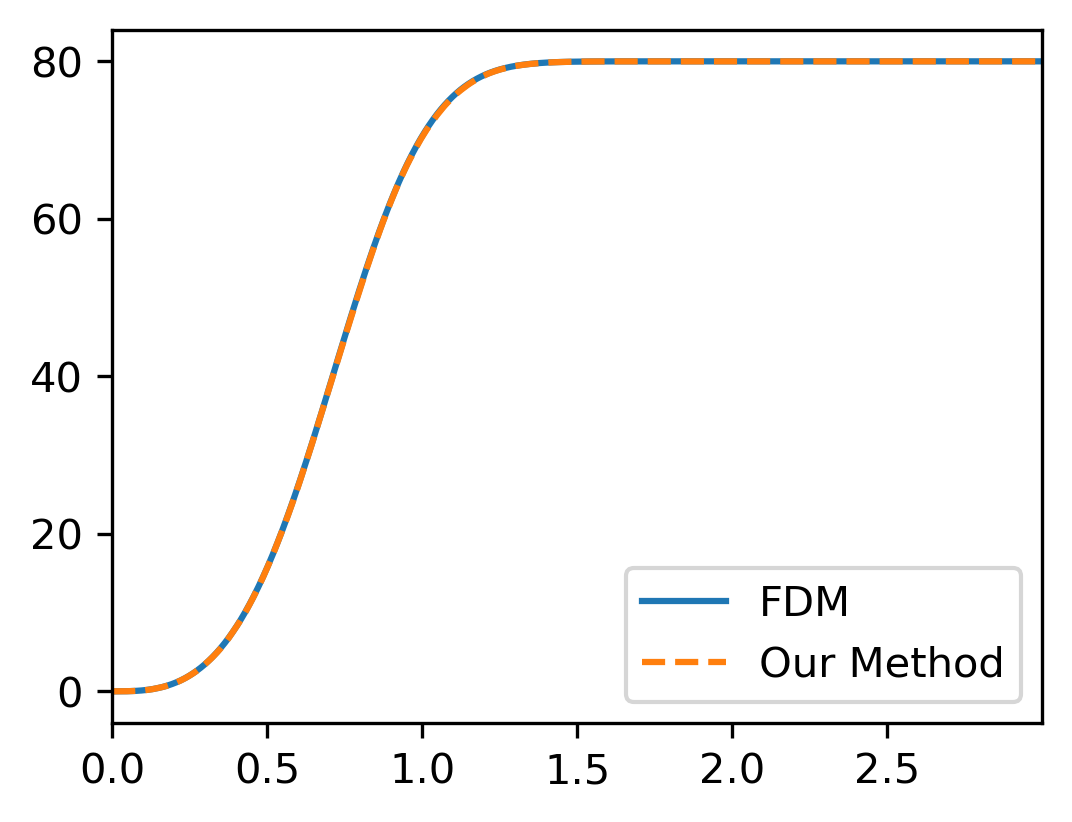

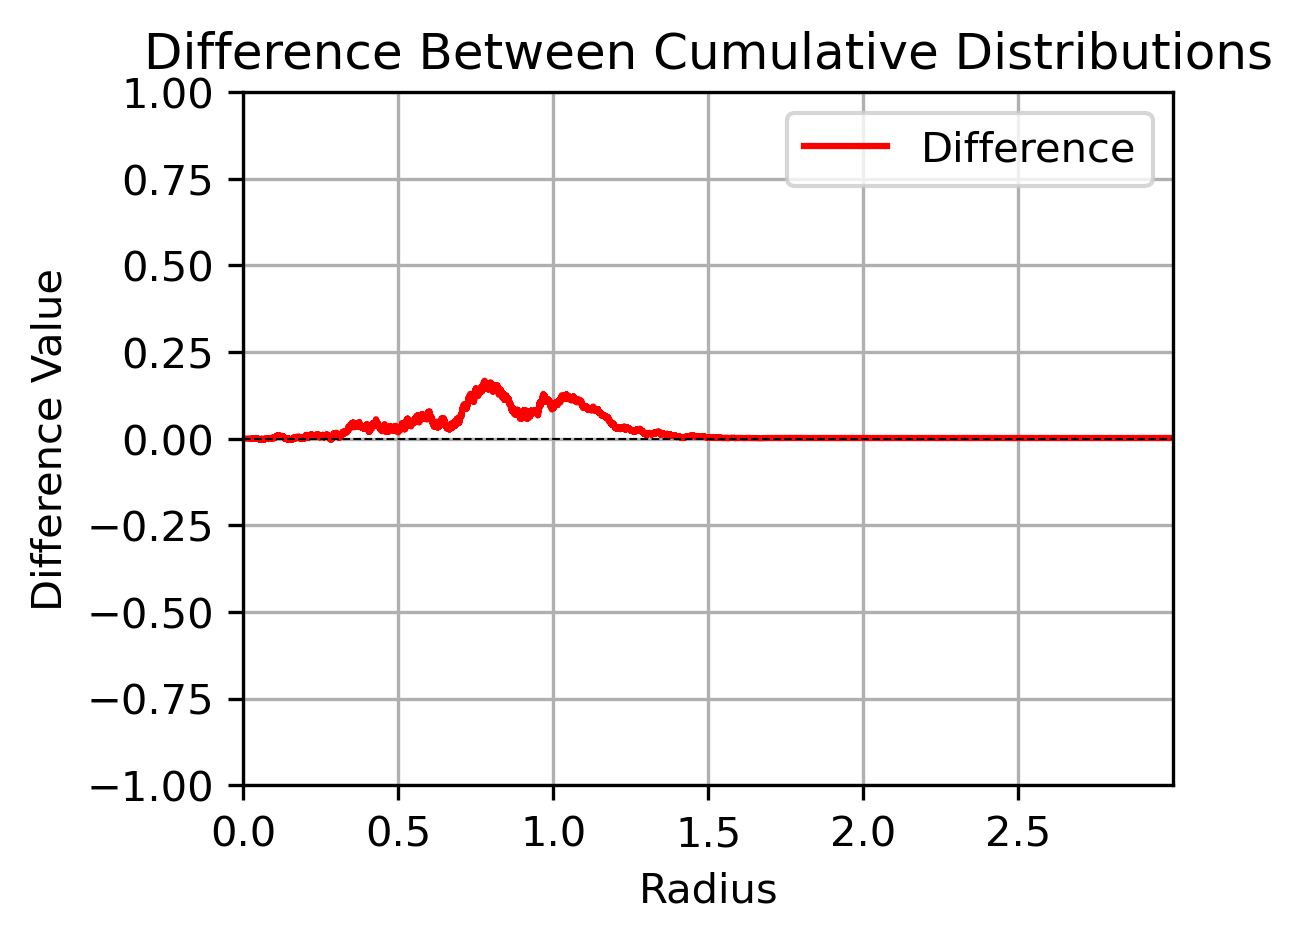

--- Build time 0.012045860290527344 s ---
--- Total time 1900.6491136550903 s ---


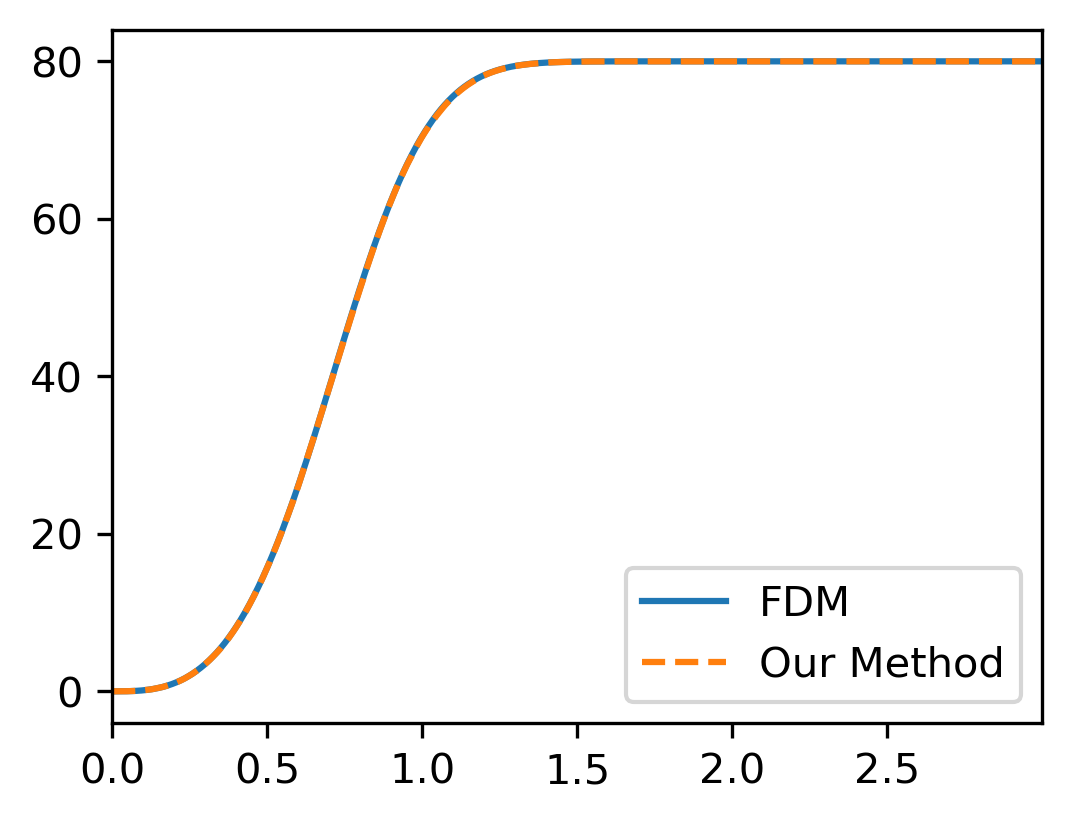

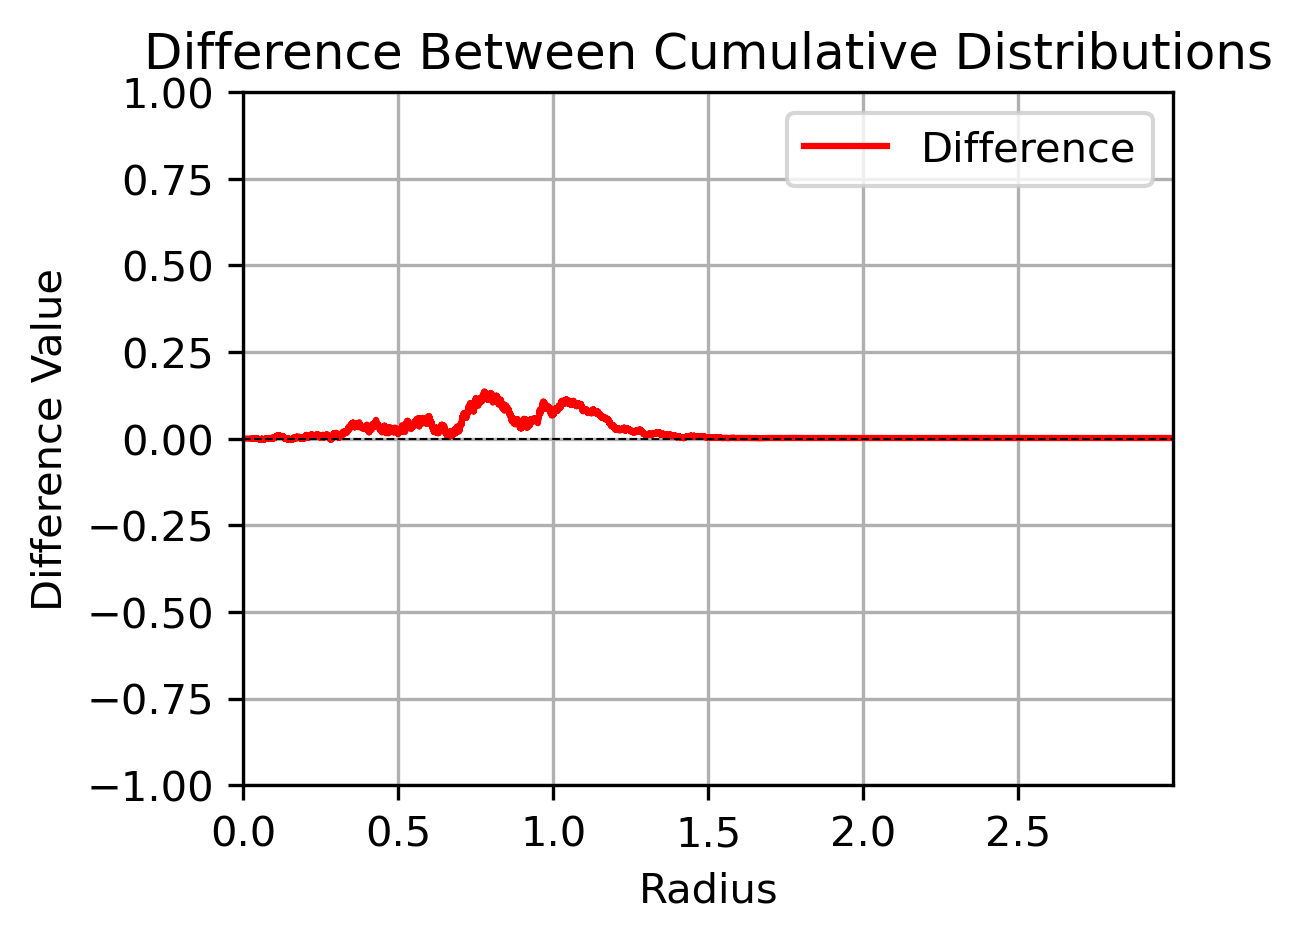

--- Build time 0.0 s ---
--- Total time 151.55880618095398 s ---


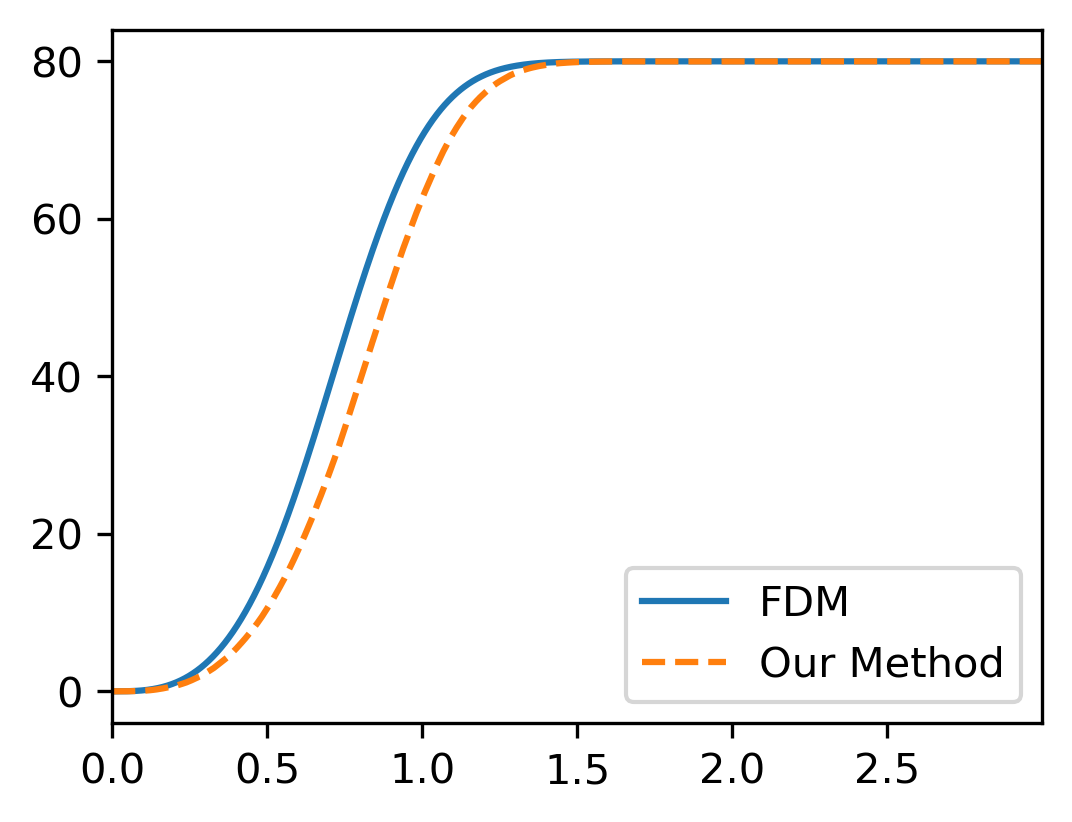

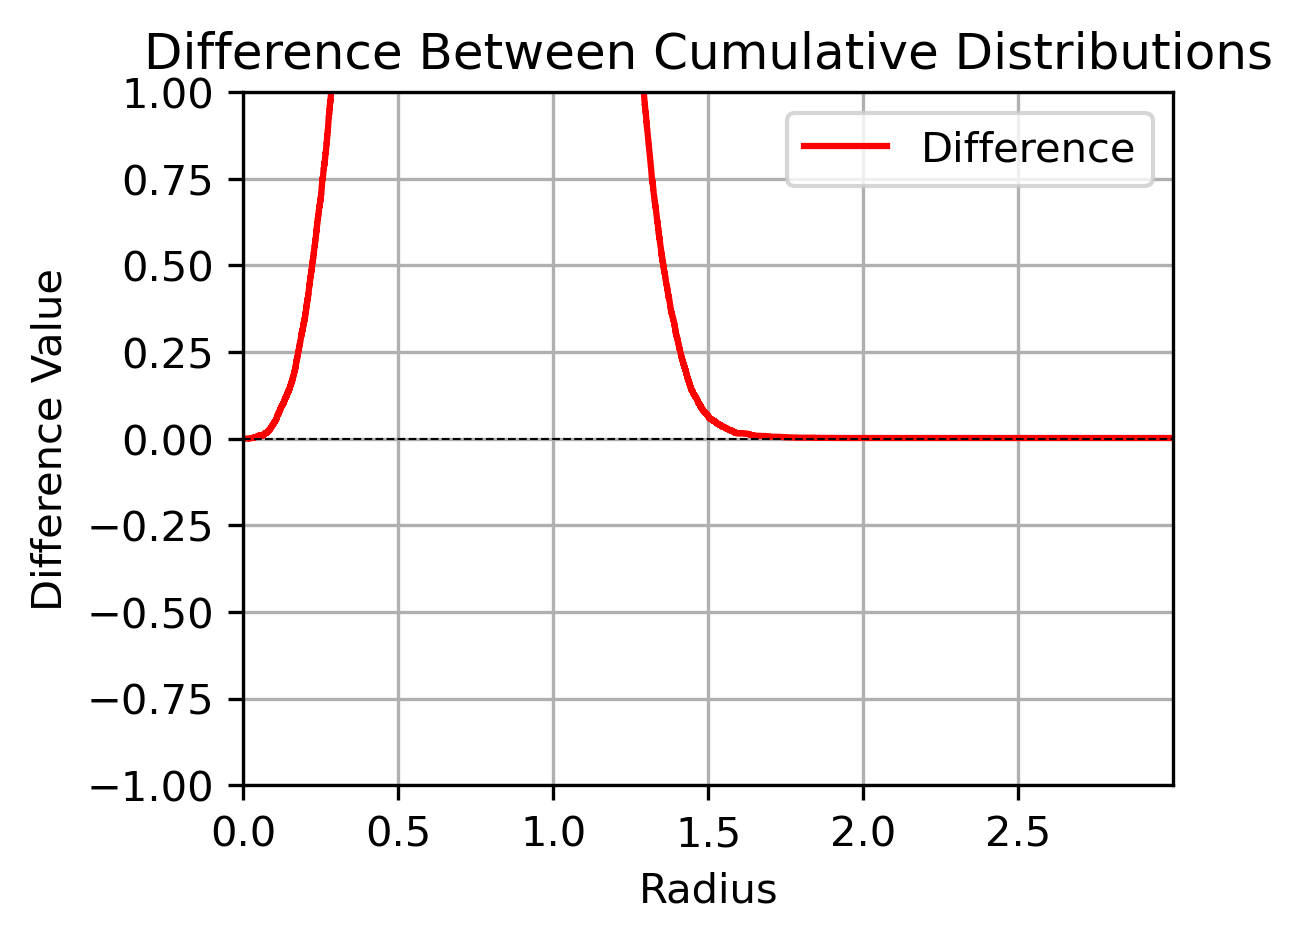

--- Build time 0.0 s ---
--- Total time 147.44306111335754 s ---


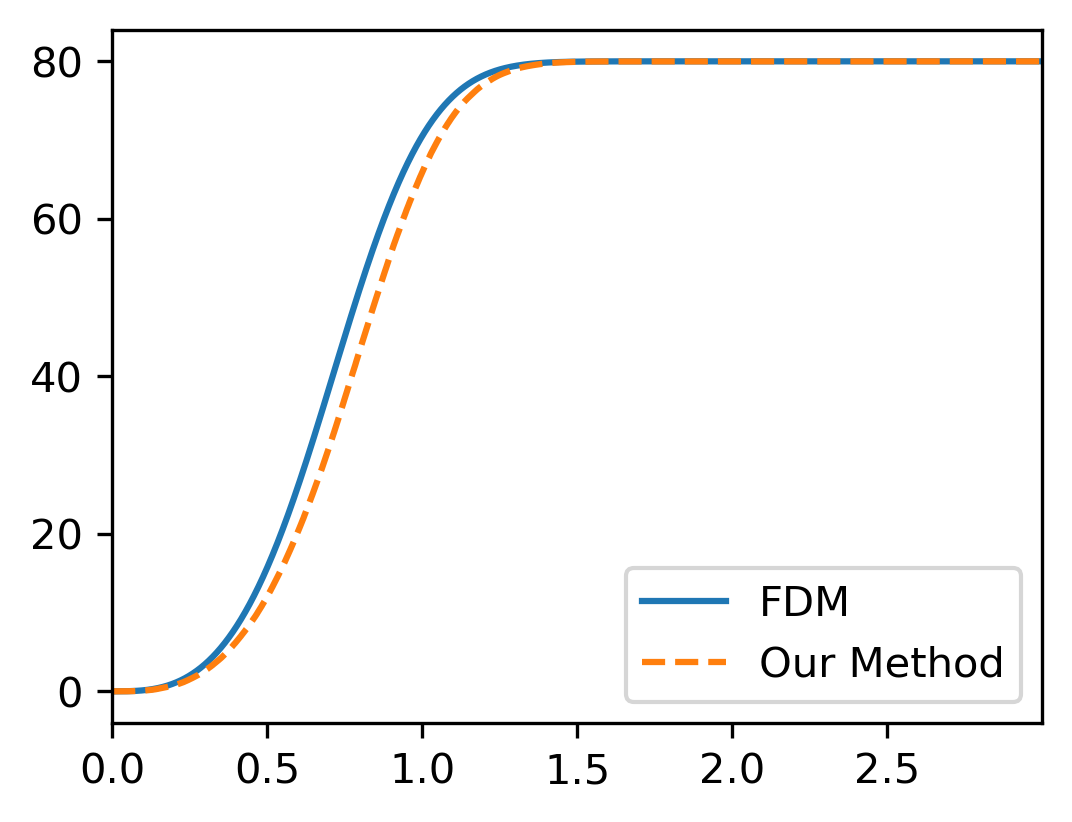

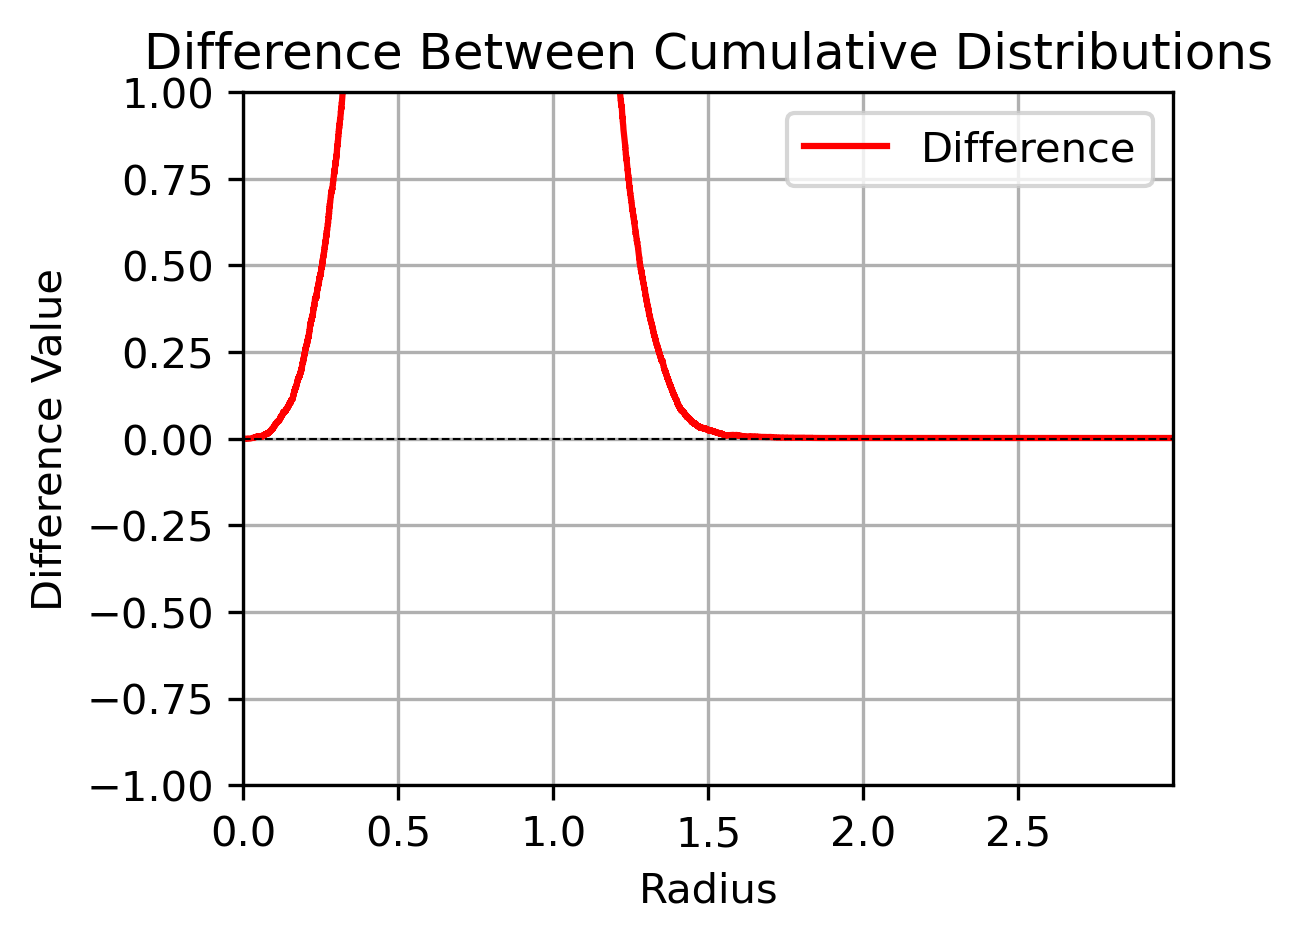

--- Build time 0.0 s ---
--- Total time 148.30328011512756 s ---


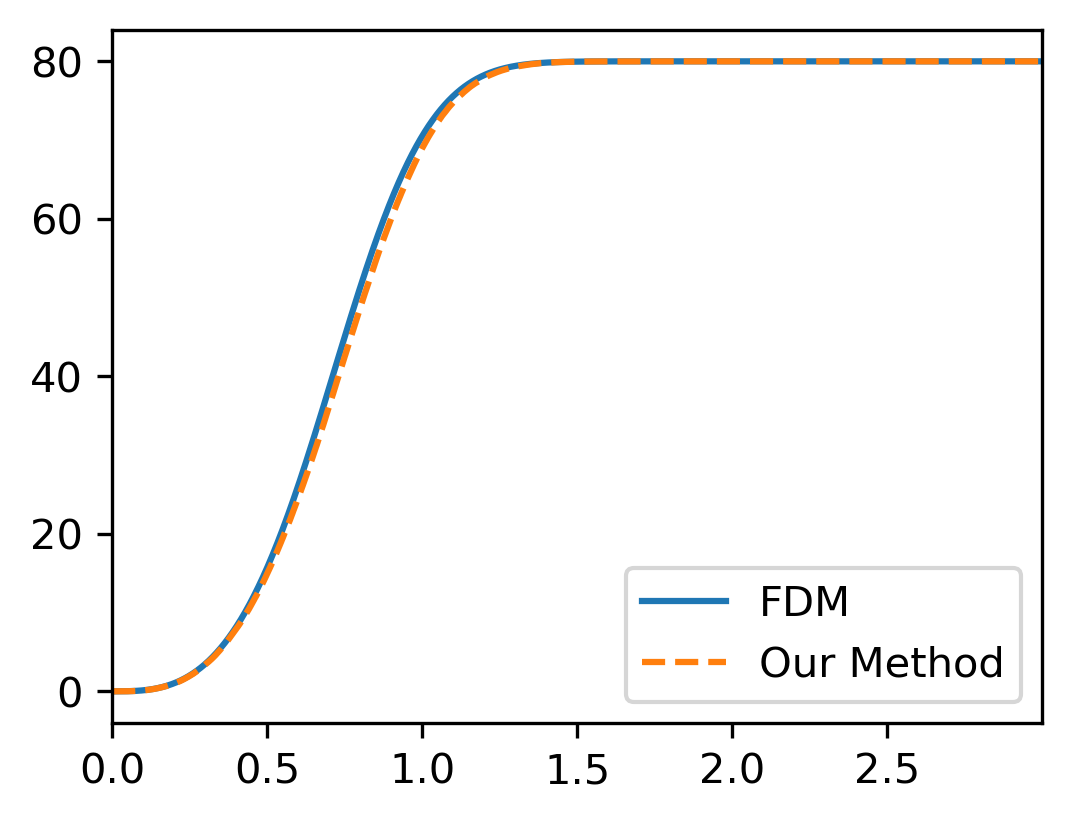

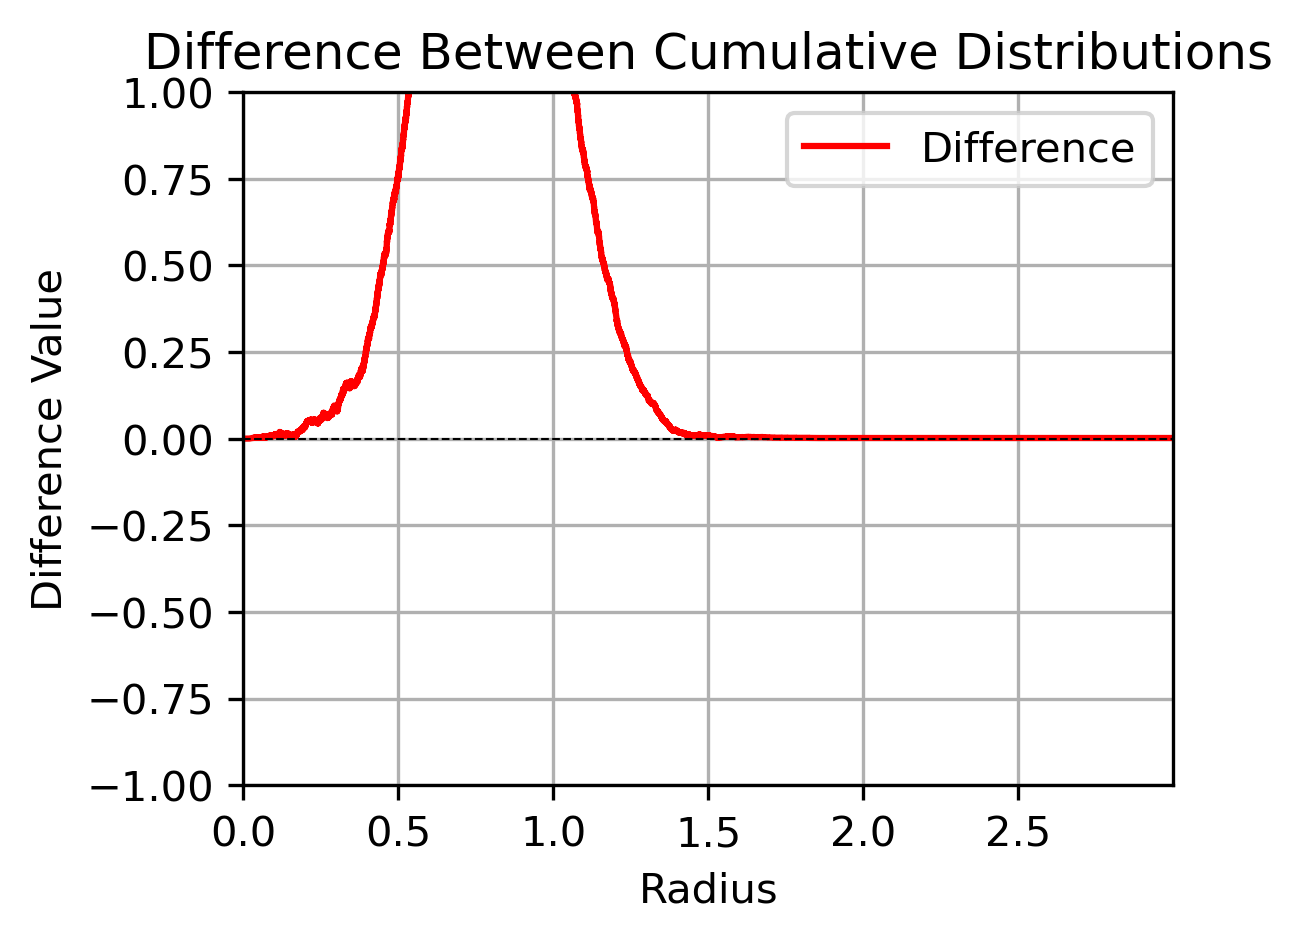

--- Build time 0.0 s ---
--- Total time 151.23941850662231 s ---


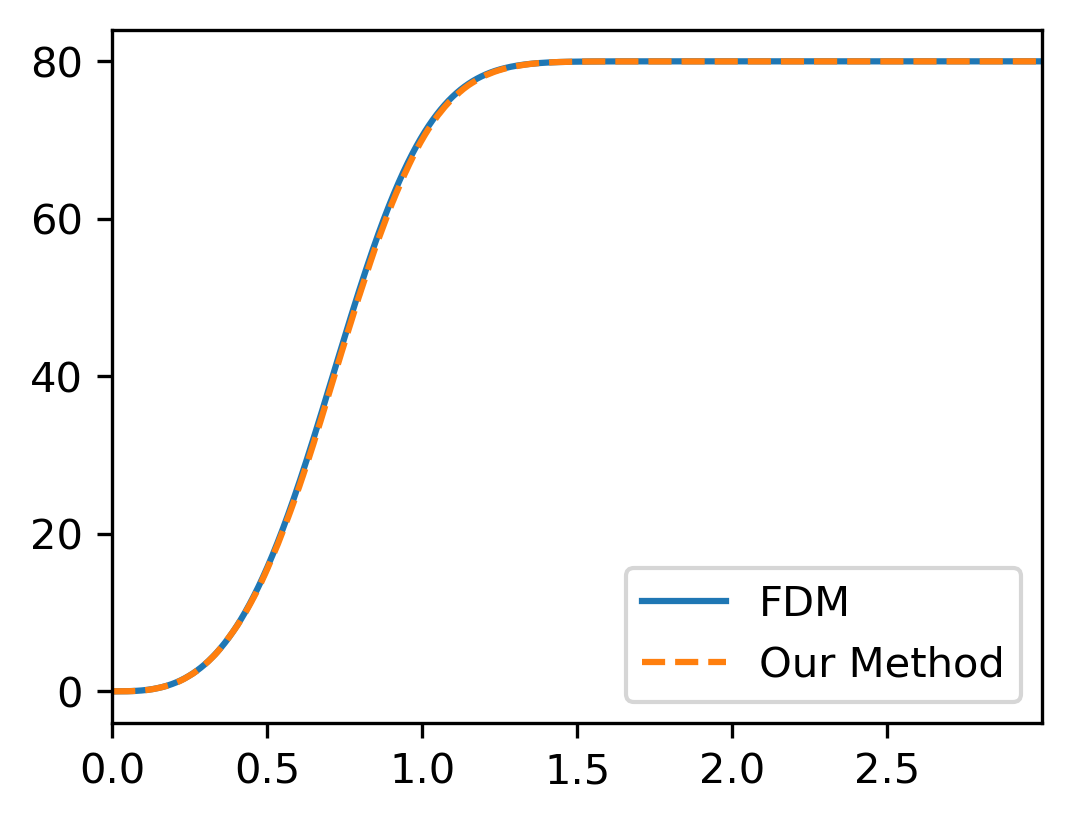

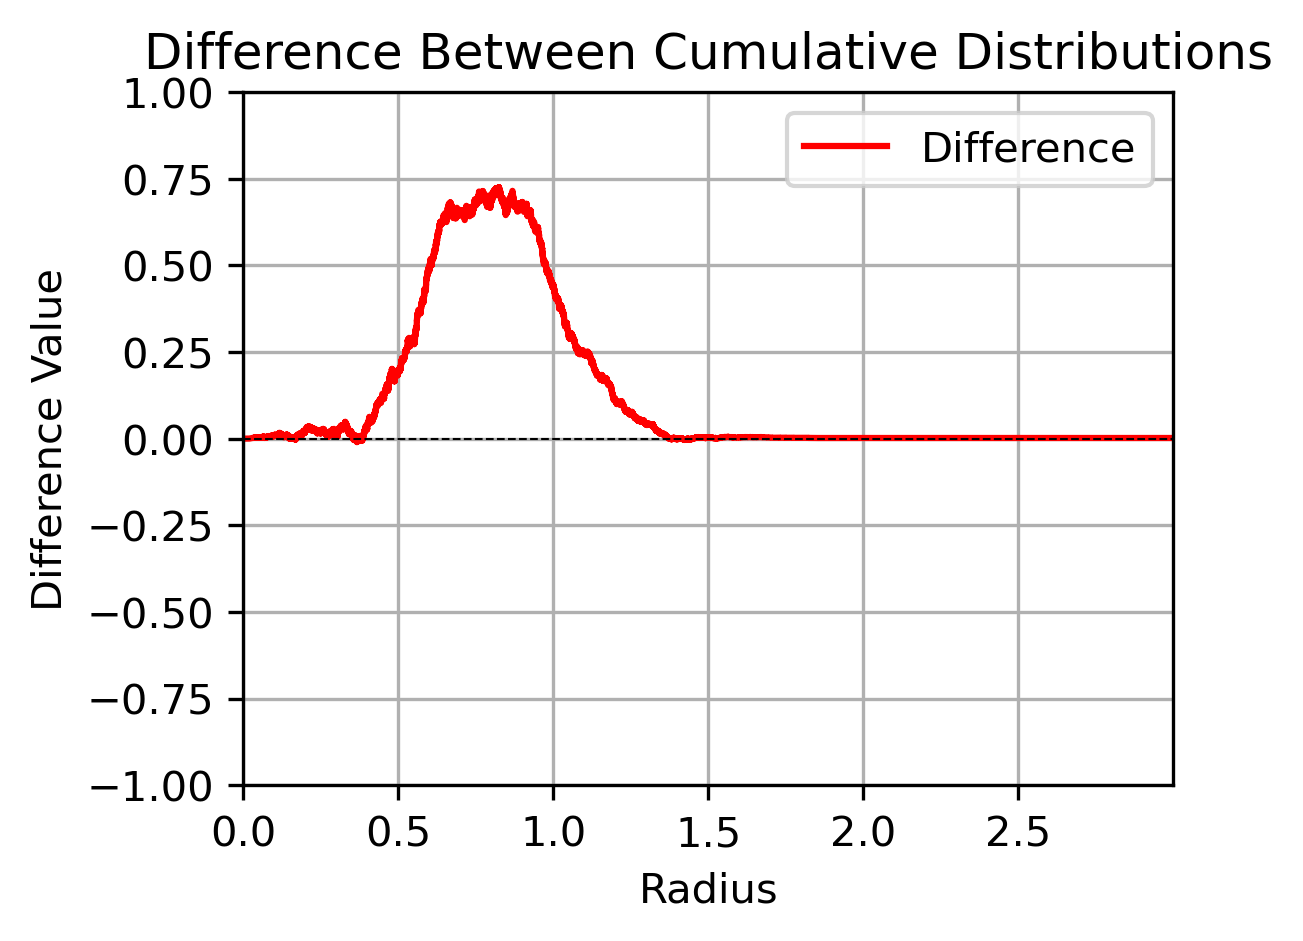

--- Build time 0.01551198959350586 s ---
--- Total time 173.1177854537964 s ---


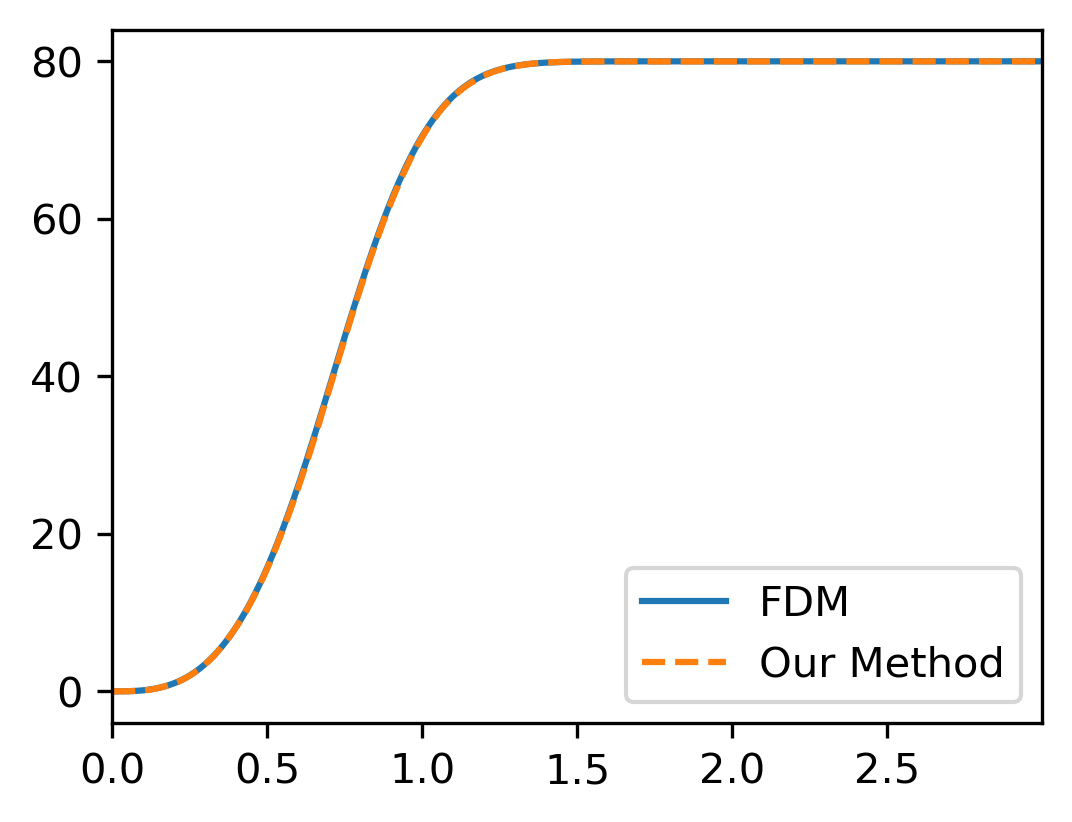

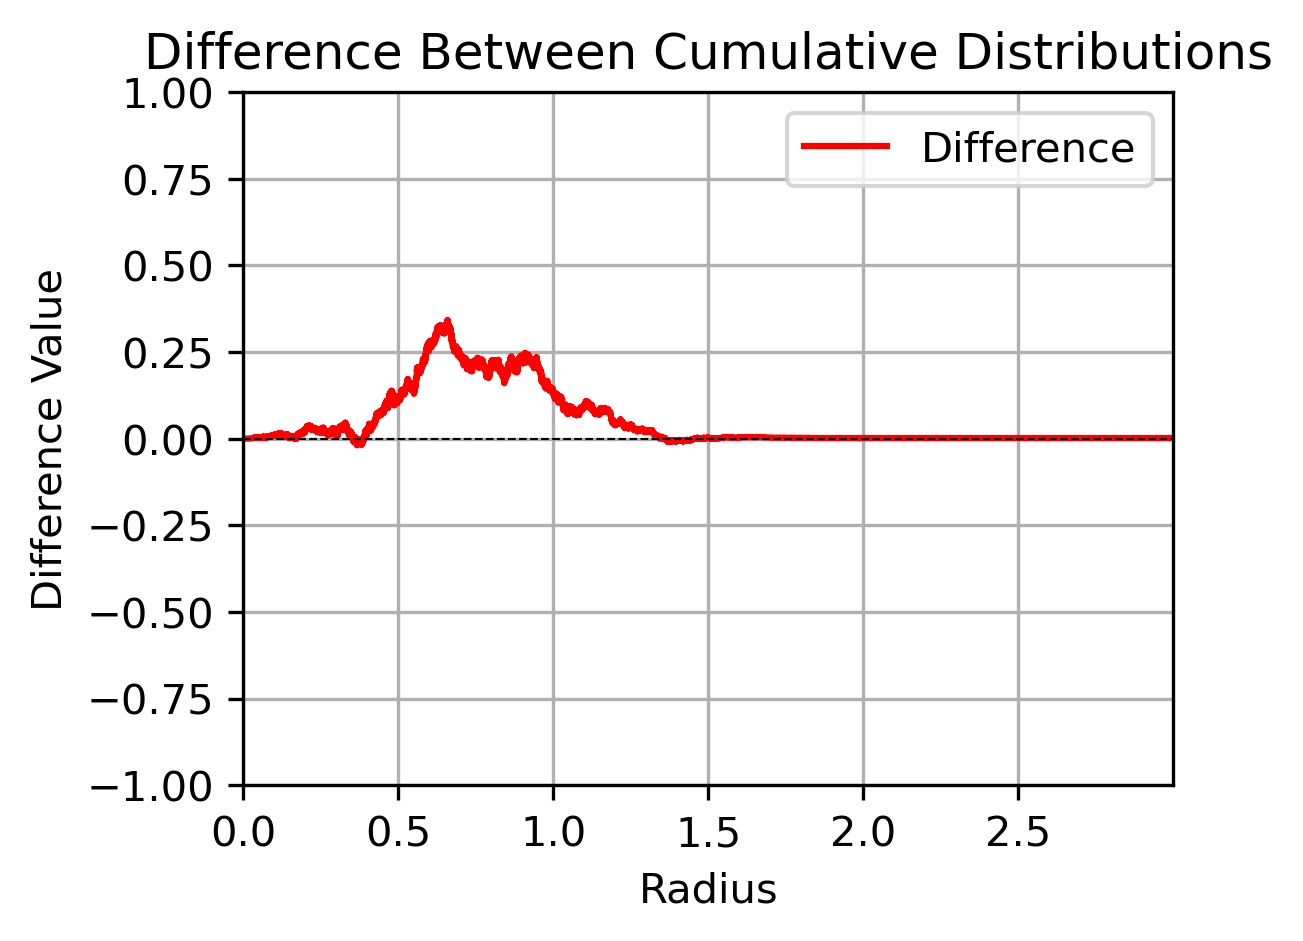

--- Build time 0.0 s ---
--- Total time 327.1227374076843 s ---


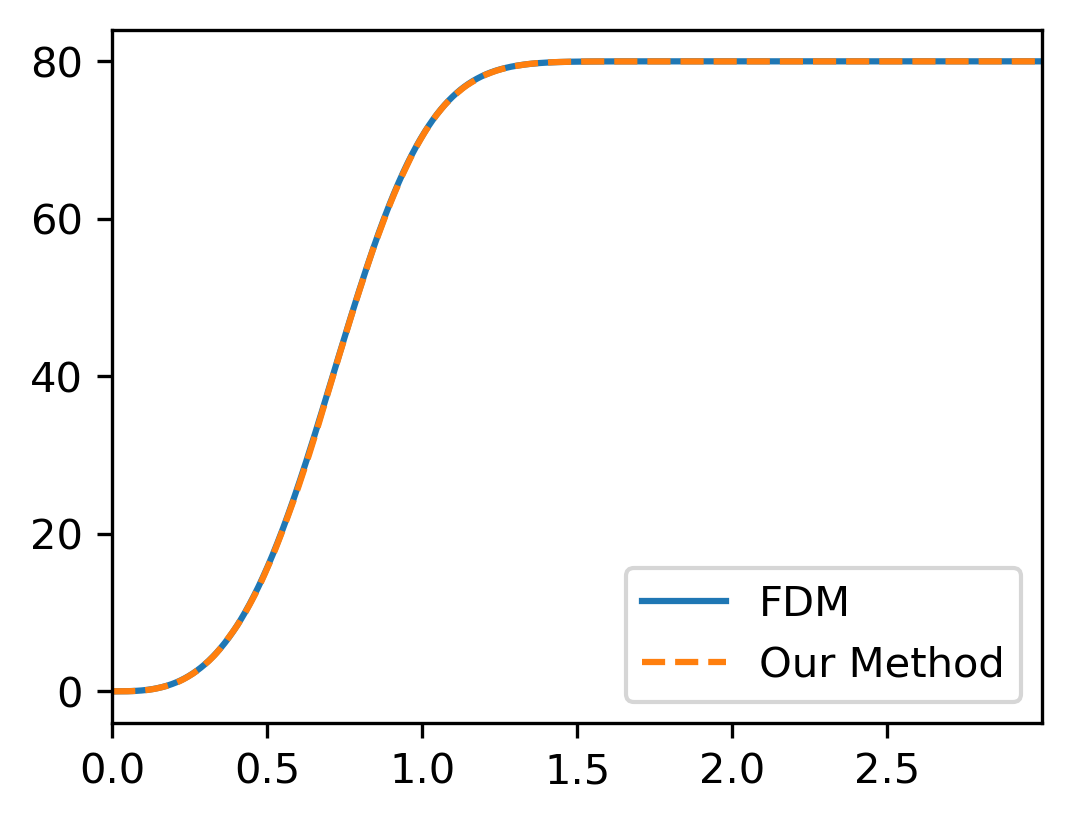

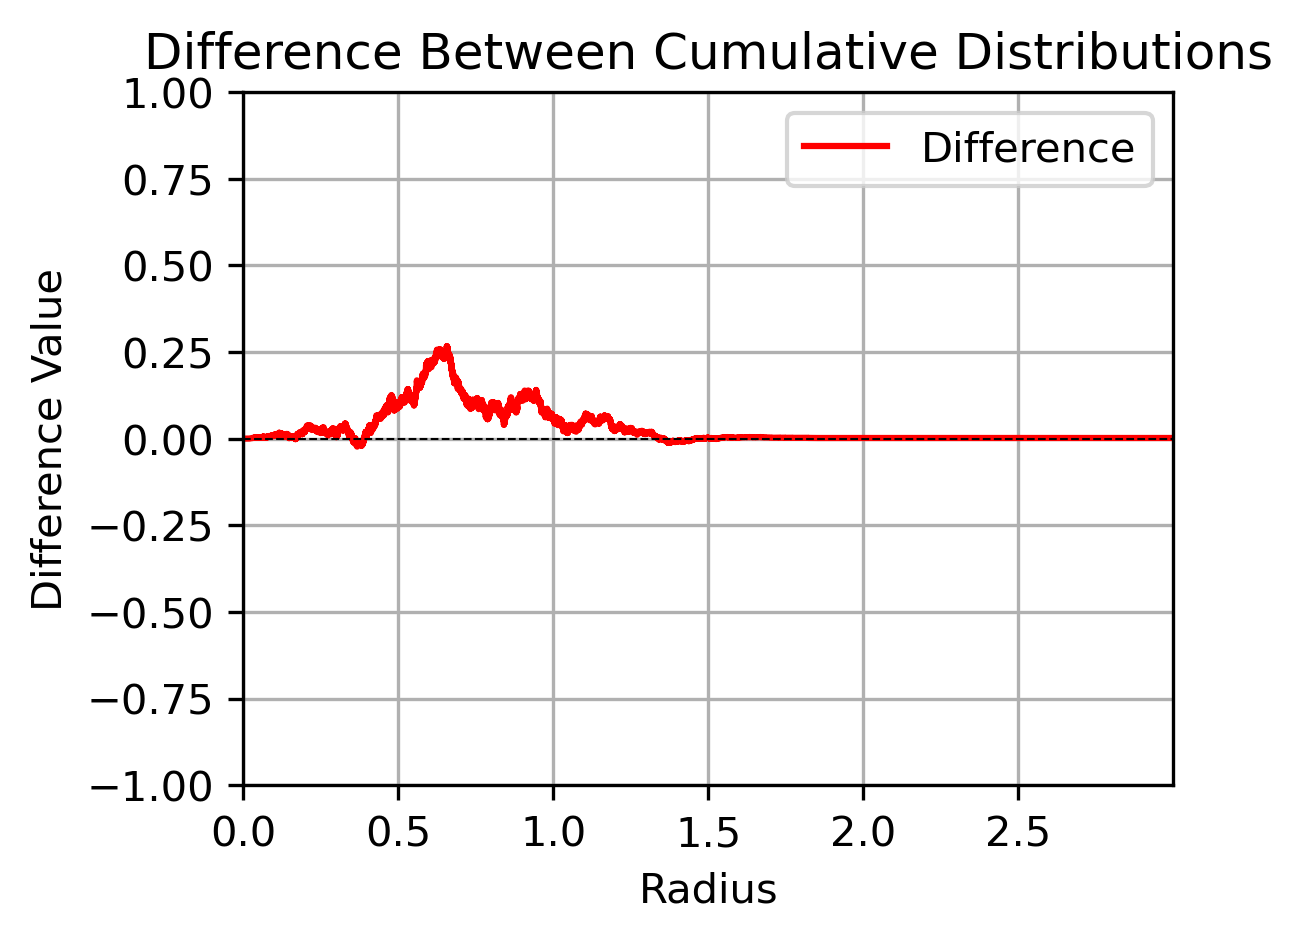

--- Build time 0.0 s ---
--- Total time 1748.8084530830383 s ---


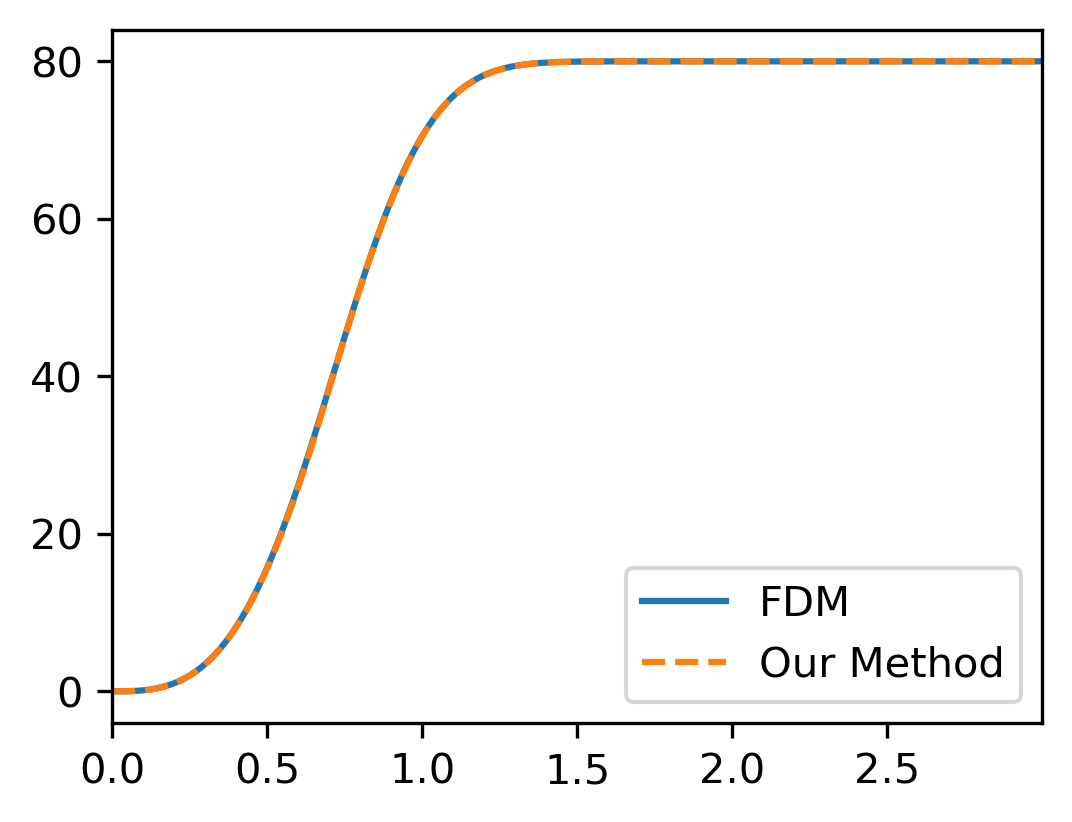

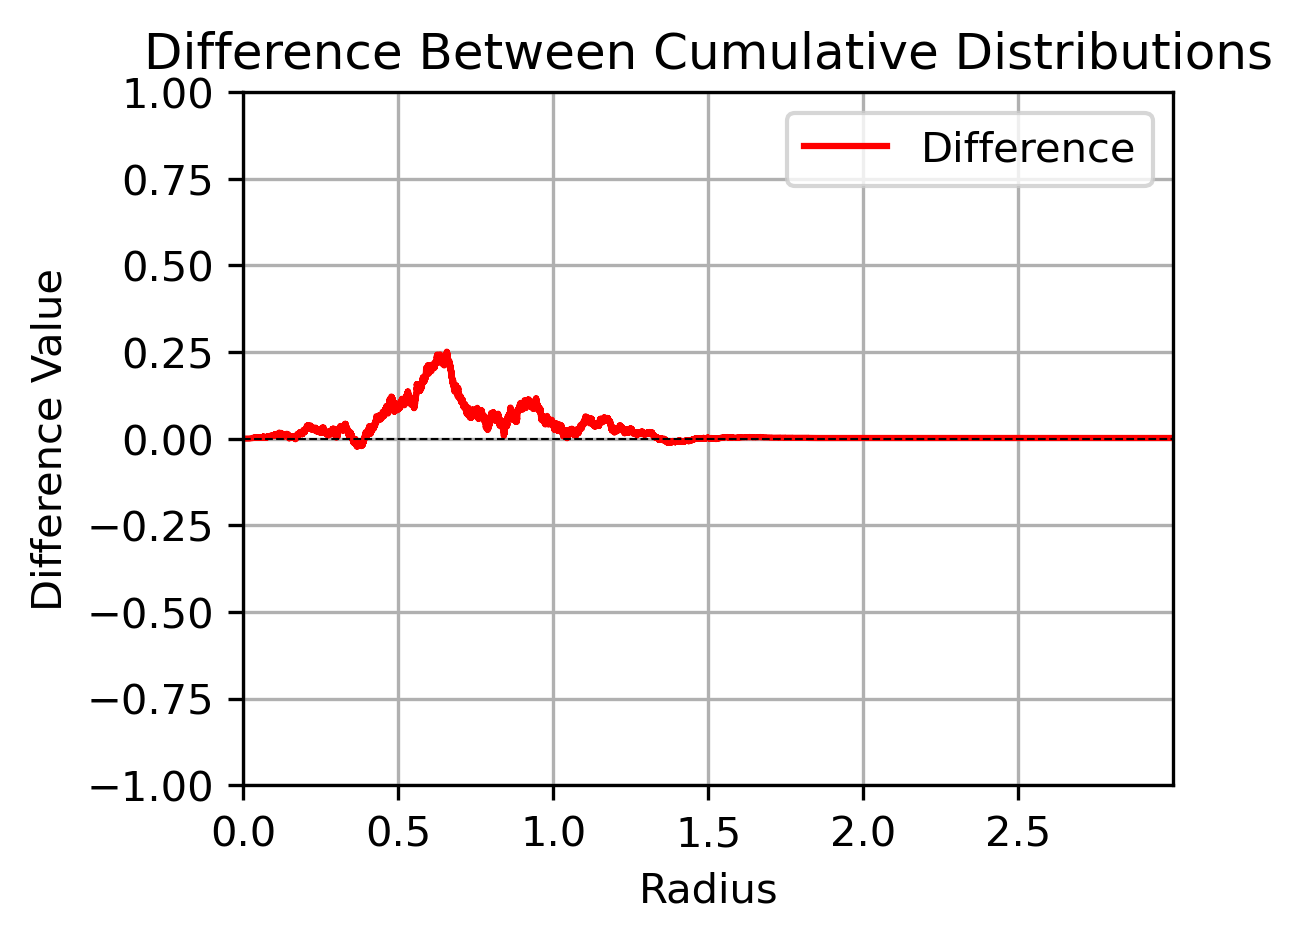

--- Build time 0.0 s ---
--- Total time 83.88538646697998 s ---


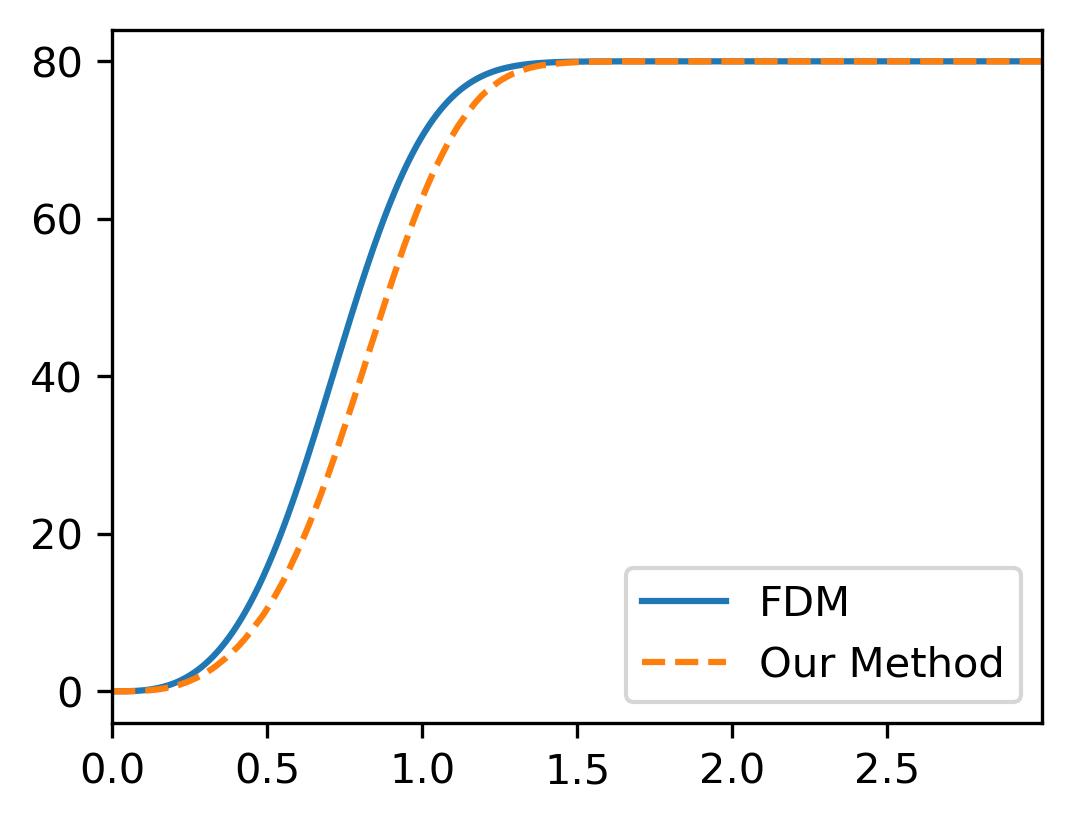

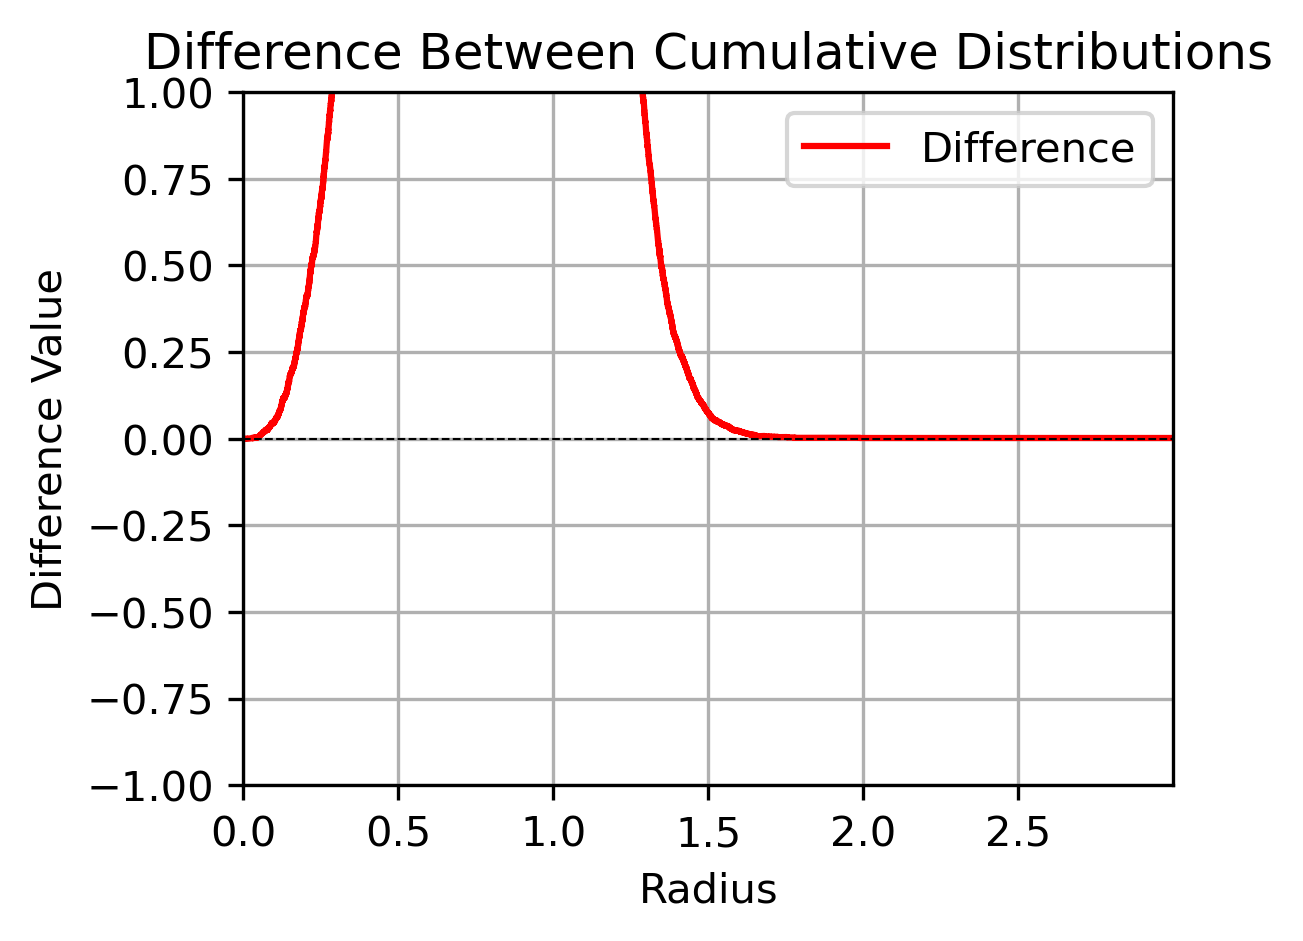

--- Build time 0.0 s ---
--- Total time 81.49063777923584 s ---


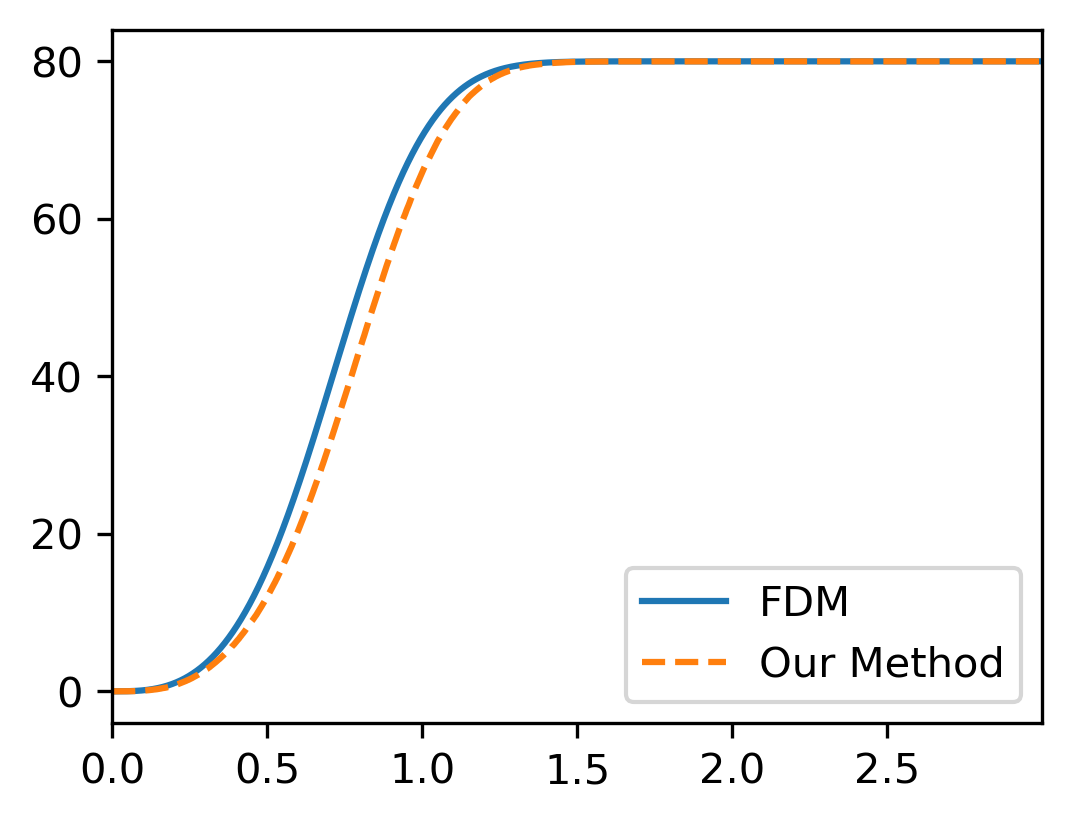

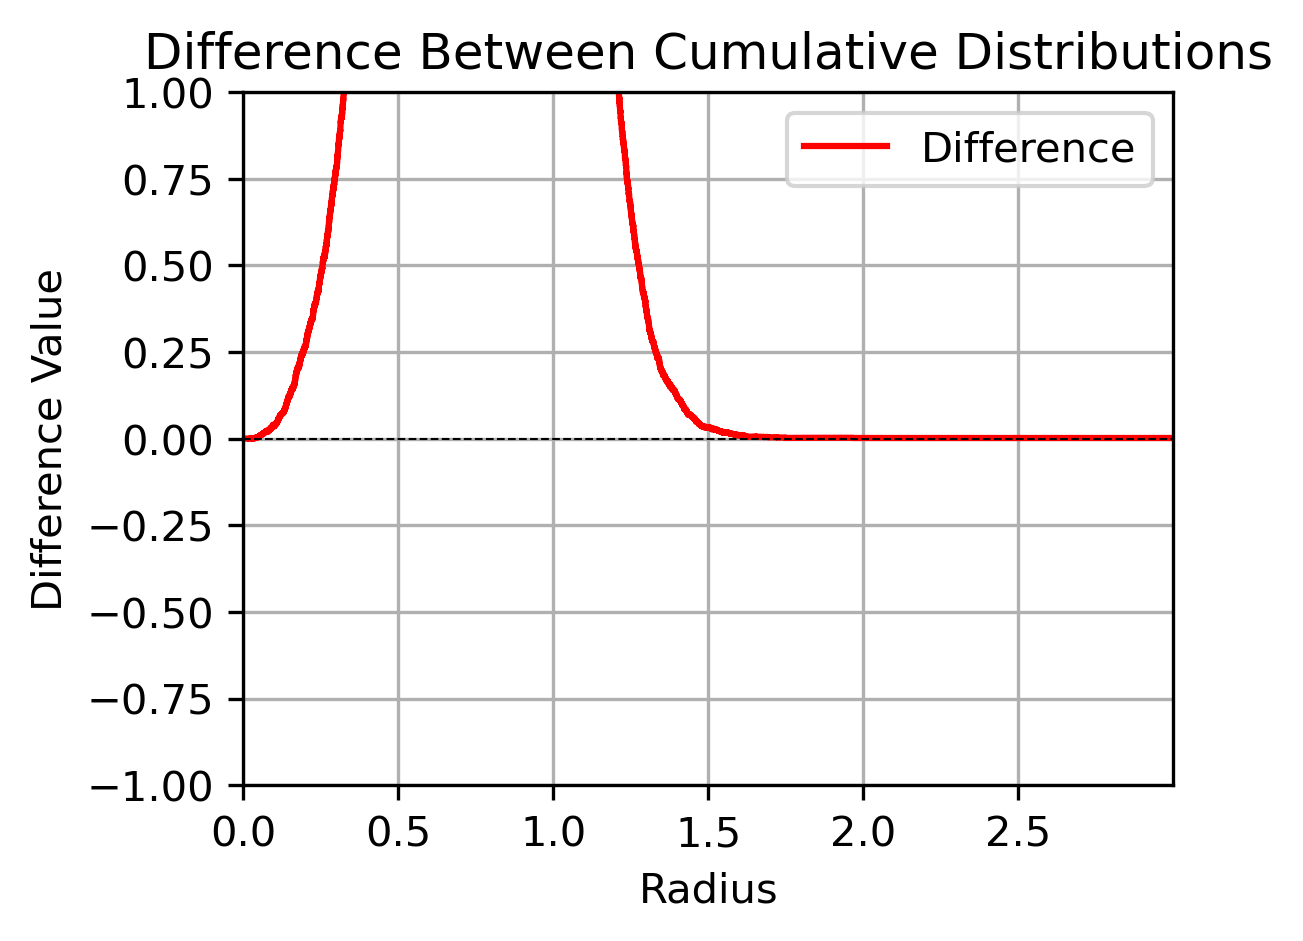

--- Build time 0.0 s ---
--- Total time 81.96165657043457 s ---


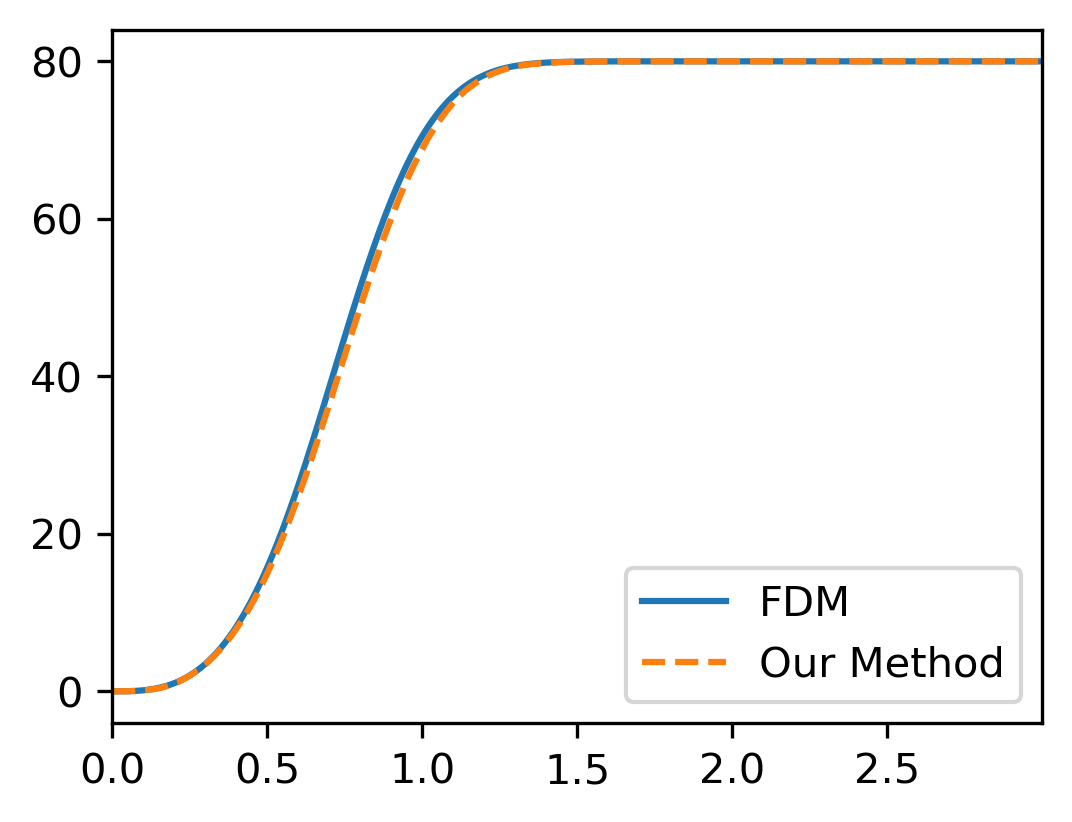

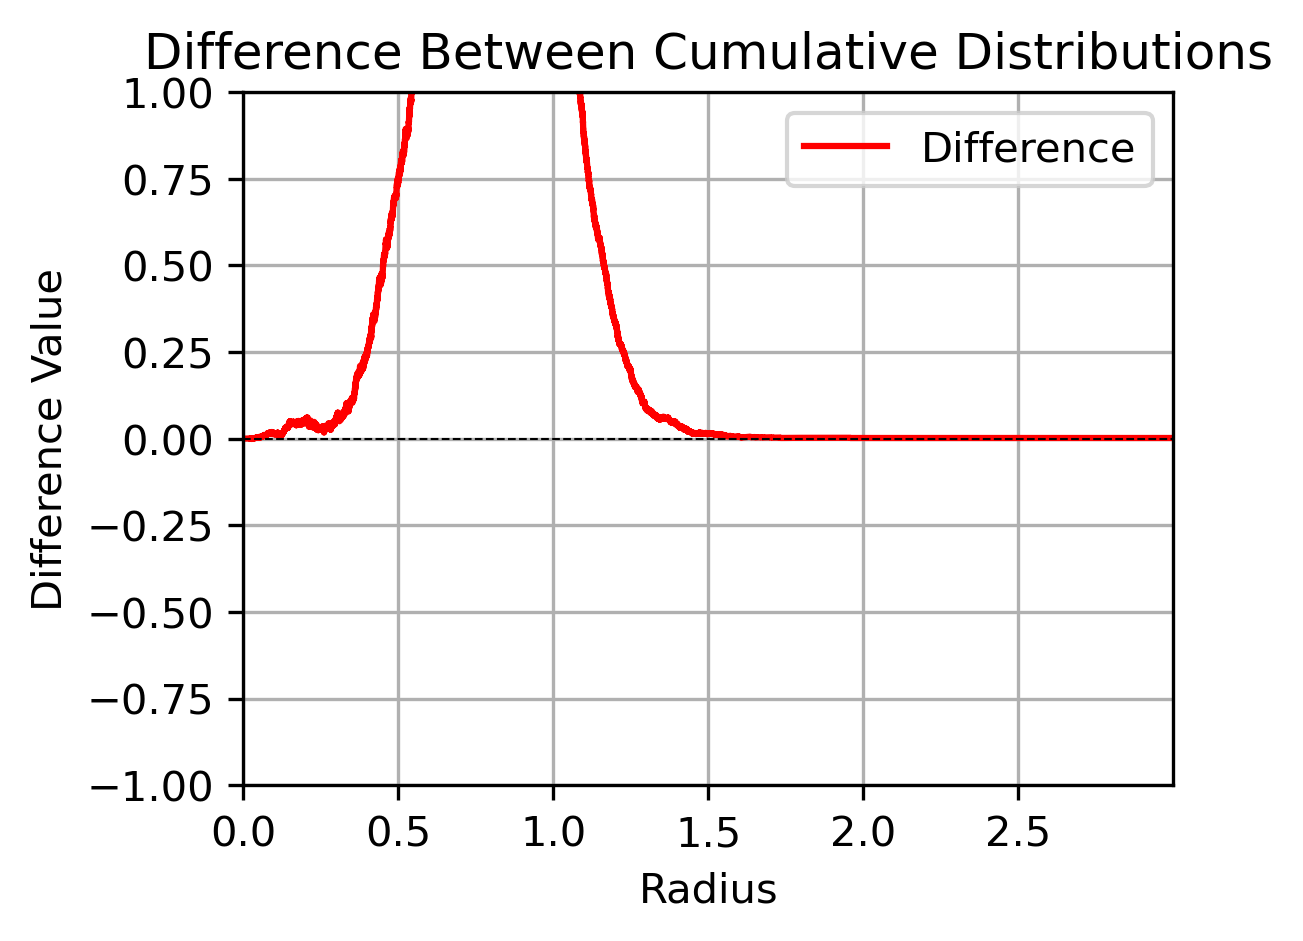

--- Build time 0.0 s ---
--- Total time 85.10039949417114 s ---


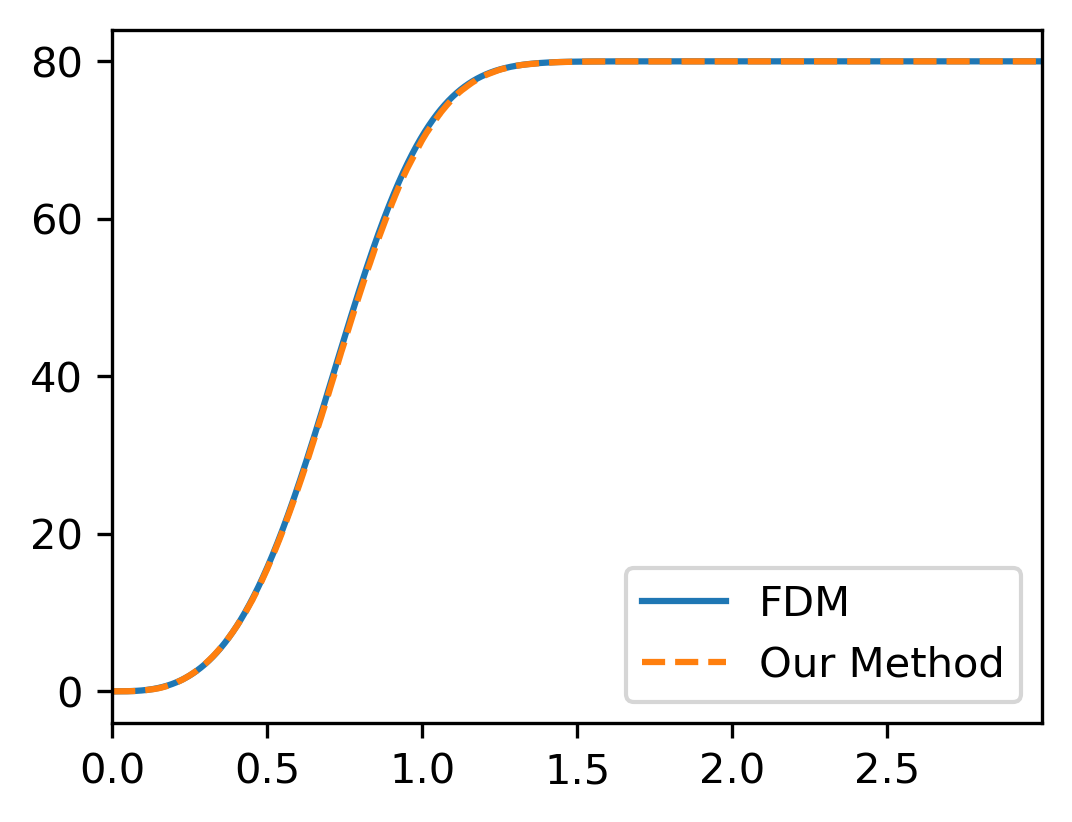

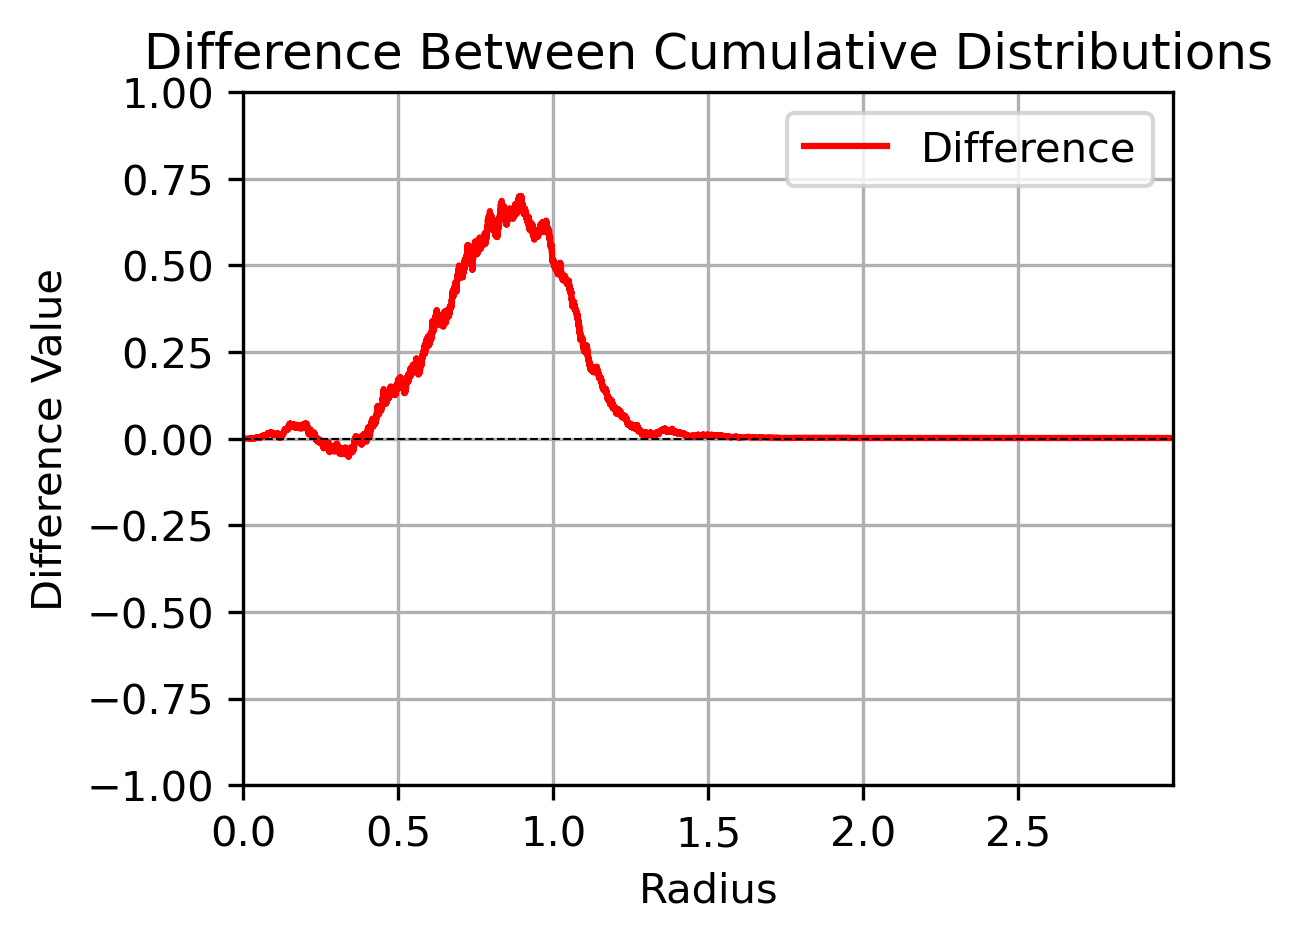

--- Build time 0.0 s ---
--- Total time 105.7564024925232 s ---


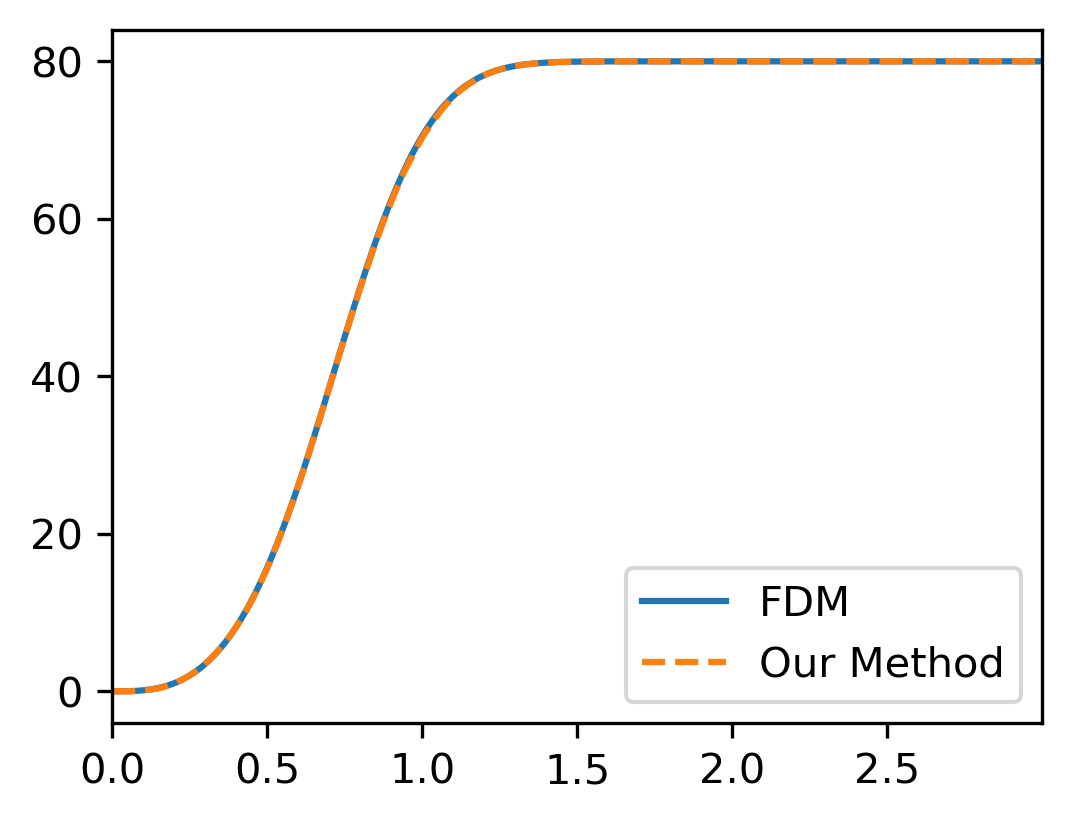

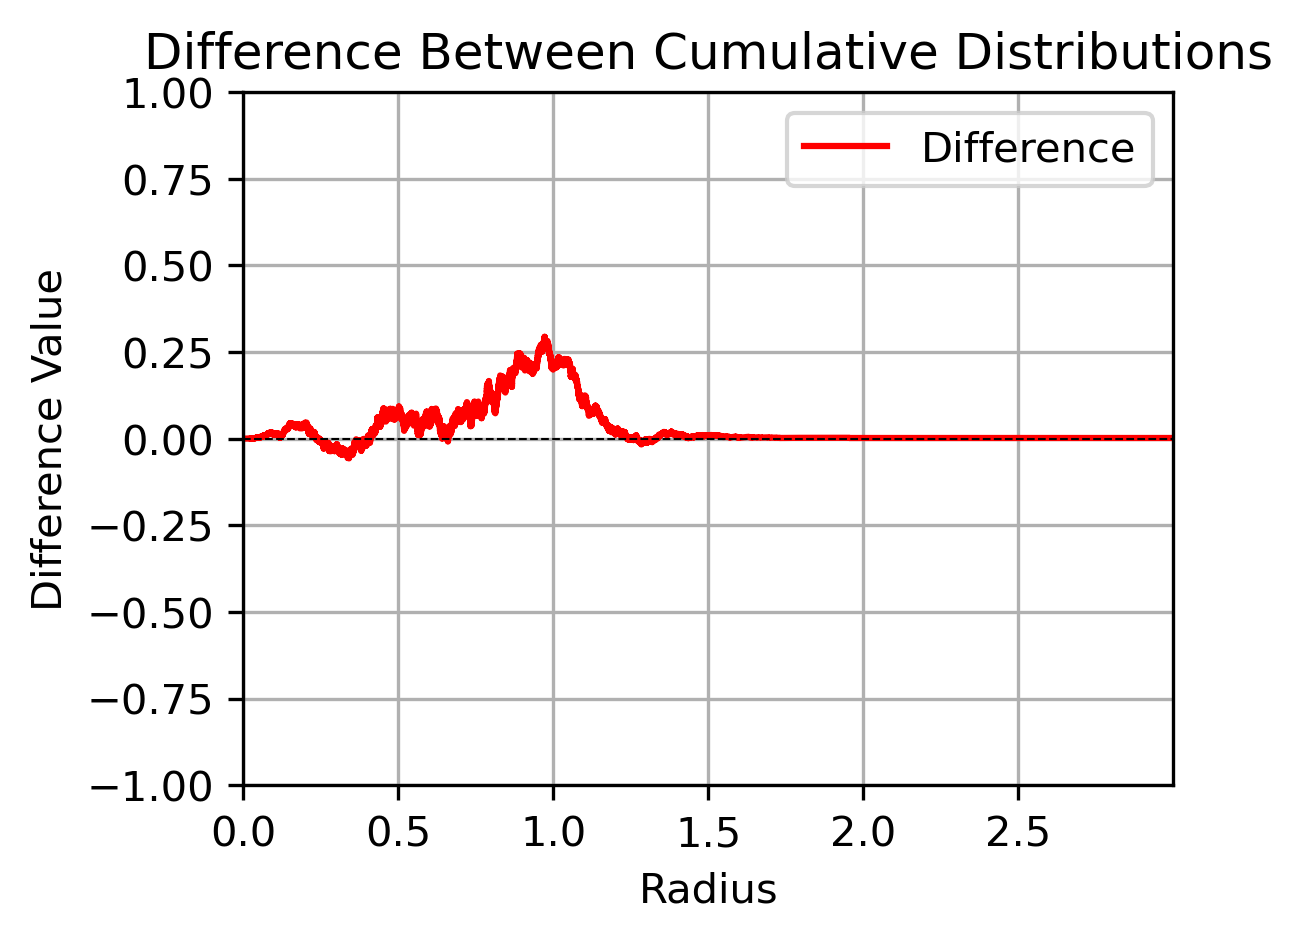

--- Build time 0.0 s ---
--- Total time 258.9084675312042 s ---


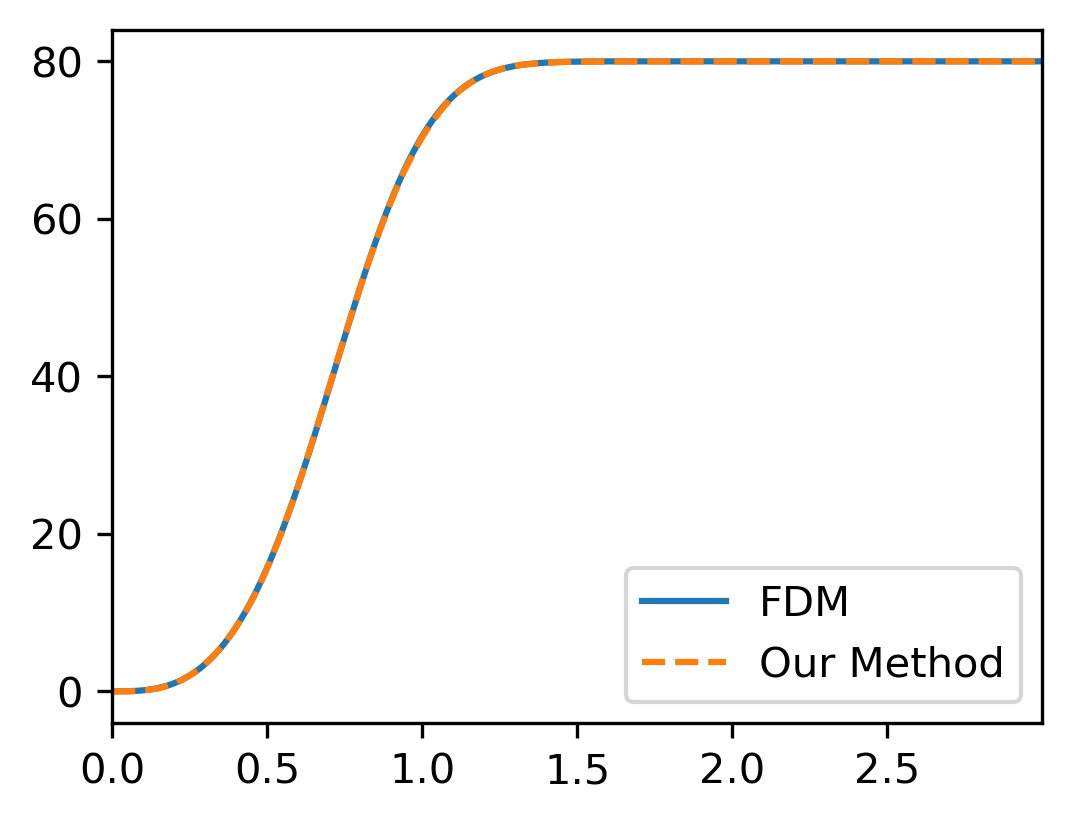

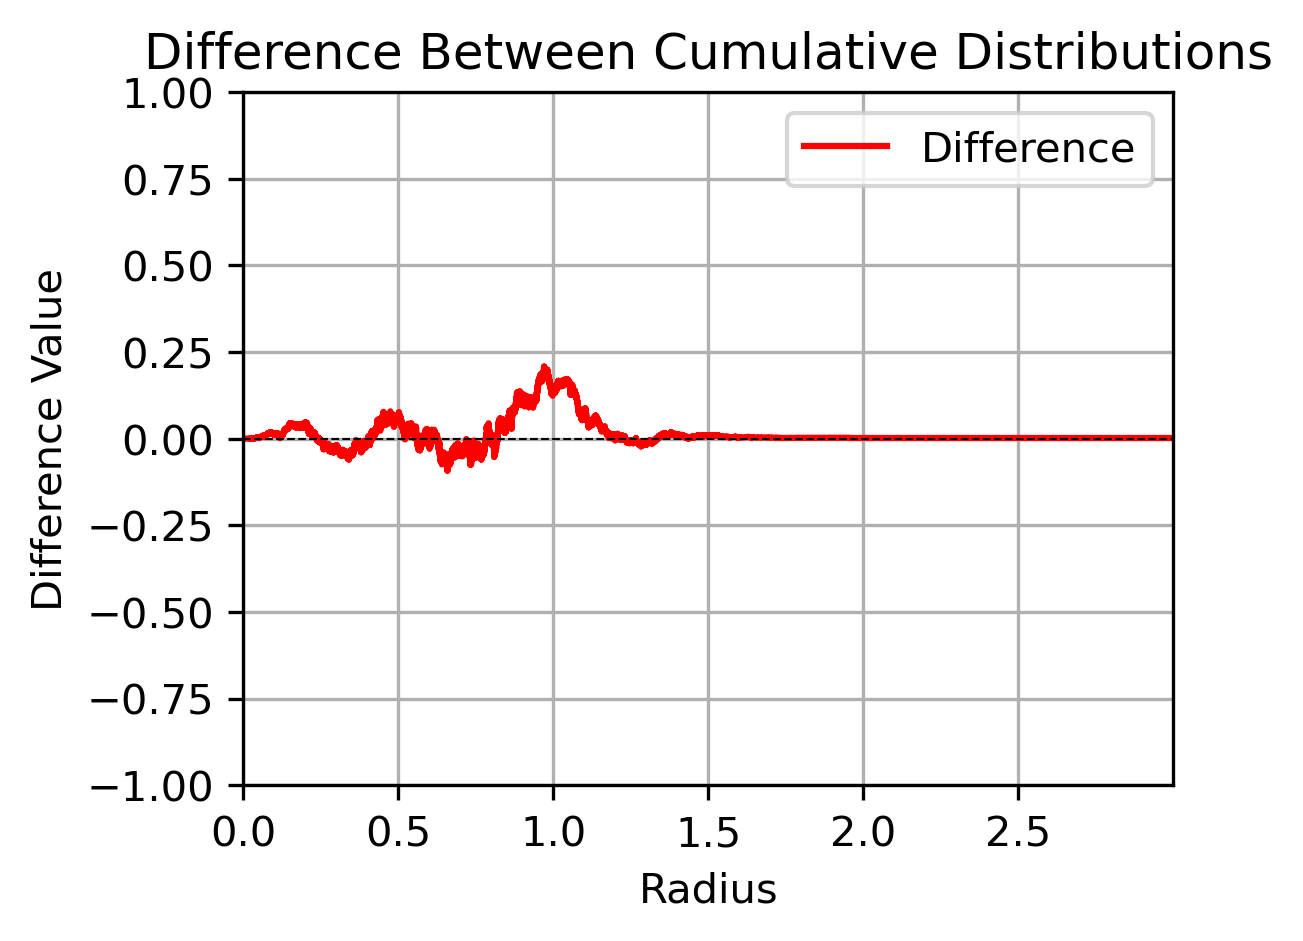

--- Build time 0.0 s ---
--- Total time 1698.753142118454 s ---


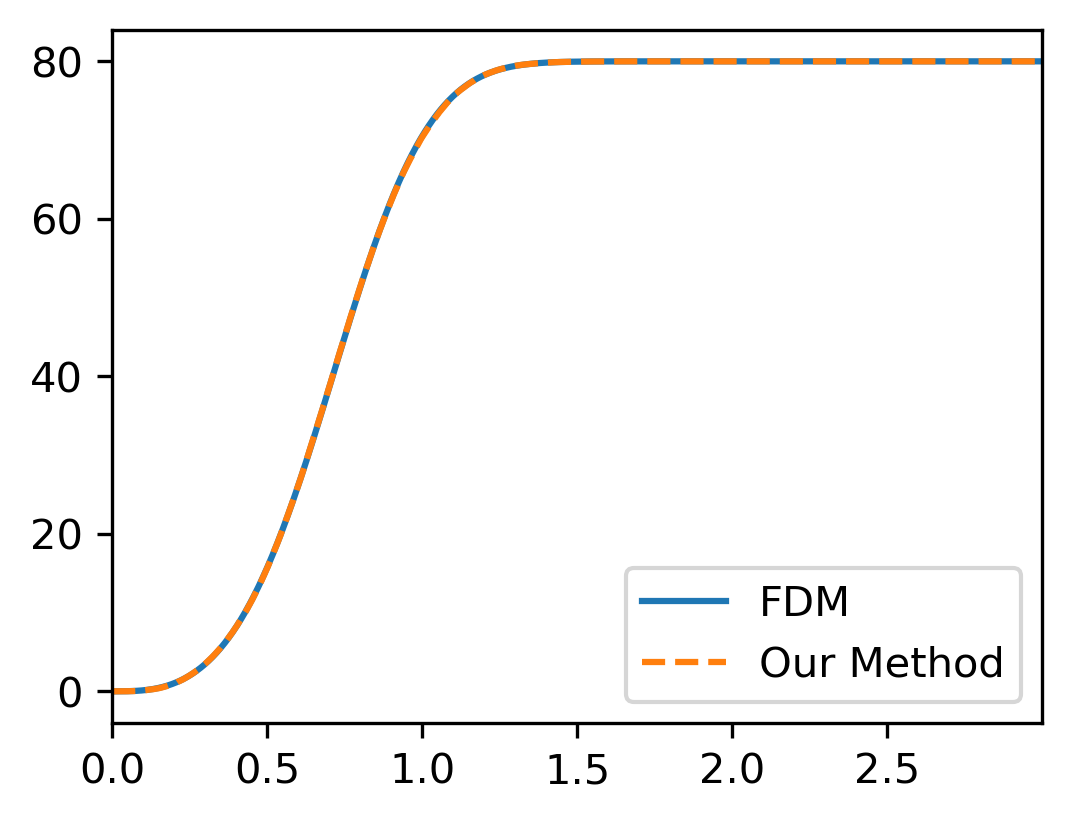

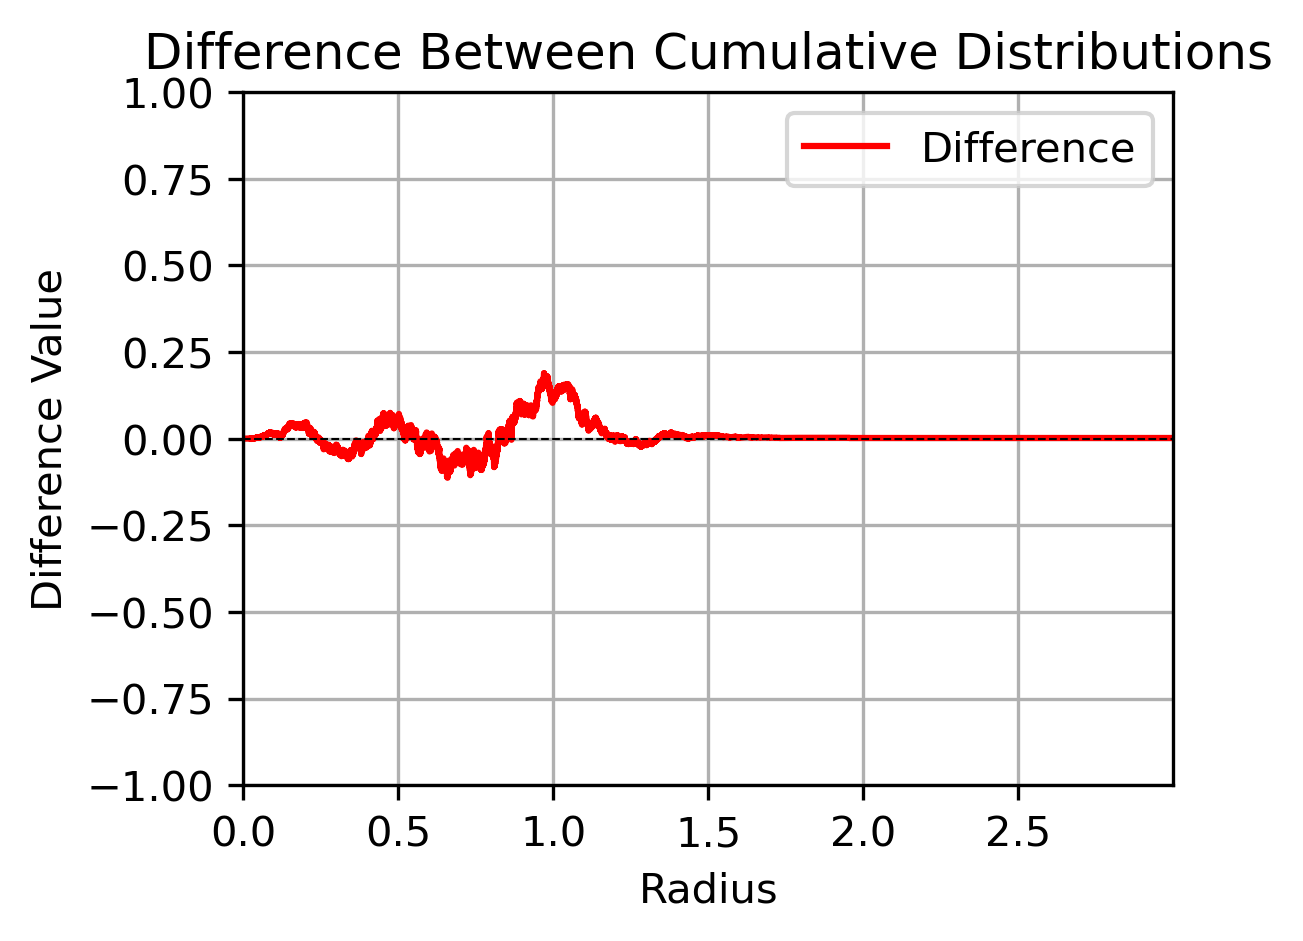

In [3]:
P0_values = [2**20, 2**19, 2**18, 2**17]
H_values = [4, 8, 16, 32, 64, 128, 256]
resultsA = []

for J0 in P0_values:
    for H1 in H_values:
        notebook_name = f'P{np.log2(J0):.2f}H{H1}'
        iniX=gen_initX(rng_key1,J=J0,r=1,pos=pos,plot=False)
        model=PKS(L=8,rng_key=rng_key2,eps=eps,H=H1)
        model.Vfunc=Vfunc
        model.M0=ModelM0
        model.X=iniX
        model.solve(t=T,t0=dt,show_num=5)

        rX=np.sqrt(np.sum(model.X**2,axis=1))
        rhocounts, _ = np.histogram(rX, bins=r[r<maxrplt])

        '''Cumlative'''
        h1,bins=np.histogram(rX,bins=r[r<maxrplt])
        h1=h1/(0.0+model.P)
        Frho_model=np.concatenate(([0],np.cumsum(h1)*model.M0))
        f=plt.figure(figsize=(4,3))
        ax=plt.subplot(111)
        ax.plot(r[r<maxrplt],np.cumsum(4*np.pi*rho[r<maxrplt]*r[r<maxrplt]**2*dr),label='FDM')
        ax.plot(bins,Frho_model,'--',label='Our Method')
        ax.legend()
        plt.xlim([0,bins.max()])

        plt.show()
        plt.close()

        difference = np.cumsum(4 * np.pi * rho[r < maxrplt] * r[r < maxrplt]**2 * dr) - Frho_model  # Adjust for bins
        f2 = plt.figure(figsize=(4, 3))
        ax2 = plt.subplot(111)
        ax2.plot(r[r < maxrplt], difference, label='Difference', color='red')
        ax2.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add a horizontal line at y=0
        ax2.set_ylim([-1, 1])
        ax2.legend()
        plt.xlim([0, bins.max()])
        plt.title('Difference Between Cumulative Distributions')
        plt.xlabel('Radius')
        plt.ylabel('Difference Value')
        plt.grid()
        plt.show()
        plt.close()

        area = np.trapz(np.abs(difference), r[r<maxrplt]) / ModelM0
        resultsA.append((J0, H1, area))
        del iniX, model, rX, h1, Frho_model, difference, f, f2, ax, ax2


results_array = np.array(resultsA)

In [4]:
print(resultsA)

[(1048576, 4, 0.08384607016478202), (1048576, 8, 0.05371844397099691), (1048576, 16, 0.01575131489640181), (1048576, 32, 0.00414762920437442), (1048576, 64, 0.0013653835745049071), (1048576, 128, 0.0006990245234616071), (1048576, 256, 0.0005391862875073286), (524288, 4, 0.08408925589315466), (524288, 8, 0.053961168390468904), (524288, 16, 0.015997439255775063), (524288, 32, 0.0043979708544012435), (524288, 64, 0.0016109627844099195), (524288, 128, 0.0009329885087274731), (524288, 256, 0.0007647807713918125), (262144, 4, 0.0841583371513632), (262144, 8, 0.054052128796952134), (262144, 16, 0.016156632169789988), (262144, 32, 0.0045997675451335315), (262144, 64, 0.0018405872261116104), (262144, 128, 0.0011719817652347771), (262144, 256, 0.001006285546237248), (131072, 4, 0.08370705679836556), (131072, 8, 0.053588817296750565), (131072, 16, 0.015601455757957437), (131072, 32, 0.00405079093837943), (131072, 64, 0.0012845307346557836), (131072, 128, 0.0008108557748977774), (131072, 256, 0.00

In [5]:
# Check if results.npy exists
if os.path.exists('A42.npy'):
    results_saved = np.load('A42.npy')
else:
    # Convert resultsA to a NumPy array if it is a list
    resultsA_array = np.array(resultsA) if isinstance(resultsA, list) else resultsA
    results_saved = np.empty((0,) + resultsA_array.shape[1:])  # Create an empty array with the same dimensions as resultsA

# Combine results and find unique entries
combined_results = np.concatenate((results_saved, results_array), axis=0)
unique_results = np.unique(combined_results, axis=0)

# Save the unique results
np.save('A42.npy', unique_results)

In [6]:
results_save = np.load('A42.npy')
print(results_save)

[[1.31072000e+05 4.00000000e+00 8.37070568e-02]
 [1.31072000e+05 8.00000000e+00 5.35888173e-02]
 [1.31072000e+05 1.60000000e+01 1.56014558e-02]
 [1.31072000e+05 3.20000000e+01 4.05079094e-03]
 [1.31072000e+05 6.40000000e+01 1.28453073e-03]
 [1.31072000e+05 1.28000000e+02 8.10855775e-04]
 [1.31072000e+05 2.56000000e+02 7.83300963e-04]
 [2.62144000e+05 4.00000000e+00 8.41583372e-02]
 [2.62144000e+05 8.00000000e+00 5.40521288e-02]
 [2.62144000e+05 1.60000000e+01 1.61566322e-02]
 [2.62144000e+05 3.20000000e+01 4.59976755e-03]
 [2.62144000e+05 6.40000000e+01 1.84058723e-03]
 [2.62144000e+05 1.28000000e+02 1.17198177e-03]
 [2.62144000e+05 2.56000000e+02 1.00628555e-03]
 [5.24288000e+05 4.00000000e+00 8.40892559e-02]
 [5.24288000e+05 8.00000000e+00 5.39611684e-02]
 [5.24288000e+05 1.60000000e+01 1.59974393e-02]
 [5.24288000e+05 3.20000000e+01 4.39797085e-03]
 [5.24288000e+05 6.40000000e+01 1.61096278e-03]
 [5.24288000e+05 1.28000000e+02 9.32988509e-04]
 [5.24288000e+05 2.56000000e+02 7.647807

In [7]:
print(unique_results)

[[1.31072000e+05 4.00000000e+00 8.37070568e-02]
 [1.31072000e+05 8.00000000e+00 5.35888173e-02]
 [1.31072000e+05 1.60000000e+01 1.56014558e-02]
 [1.31072000e+05 3.20000000e+01 4.05079094e-03]
 [1.31072000e+05 6.40000000e+01 1.28453073e-03]
 [1.31072000e+05 1.28000000e+02 8.10855775e-04]
 [1.31072000e+05 2.56000000e+02 7.83300963e-04]
 [2.62144000e+05 4.00000000e+00 8.41583372e-02]
 [2.62144000e+05 8.00000000e+00 5.40521288e-02]
 [2.62144000e+05 1.60000000e+01 1.61566322e-02]
 [2.62144000e+05 3.20000000e+01 4.59976755e-03]
 [2.62144000e+05 6.40000000e+01 1.84058723e-03]
 [2.62144000e+05 1.28000000e+02 1.17198177e-03]
 [2.62144000e+05 2.56000000e+02 1.00628555e-03]
 [5.24288000e+05 4.00000000e+00 8.40892559e-02]
 [5.24288000e+05 8.00000000e+00 5.39611684e-02]
 [5.24288000e+05 1.60000000e+01 1.59974393e-02]
 [5.24288000e+05 3.20000000e+01 4.39797085e-03]
 [5.24288000e+05 6.40000000e+01 1.61096278e-03]
 [5.24288000e+05 1.28000000e+02 9.32988509e-04]
 [5.24288000e+05 2.56000000e+02 7.647807

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


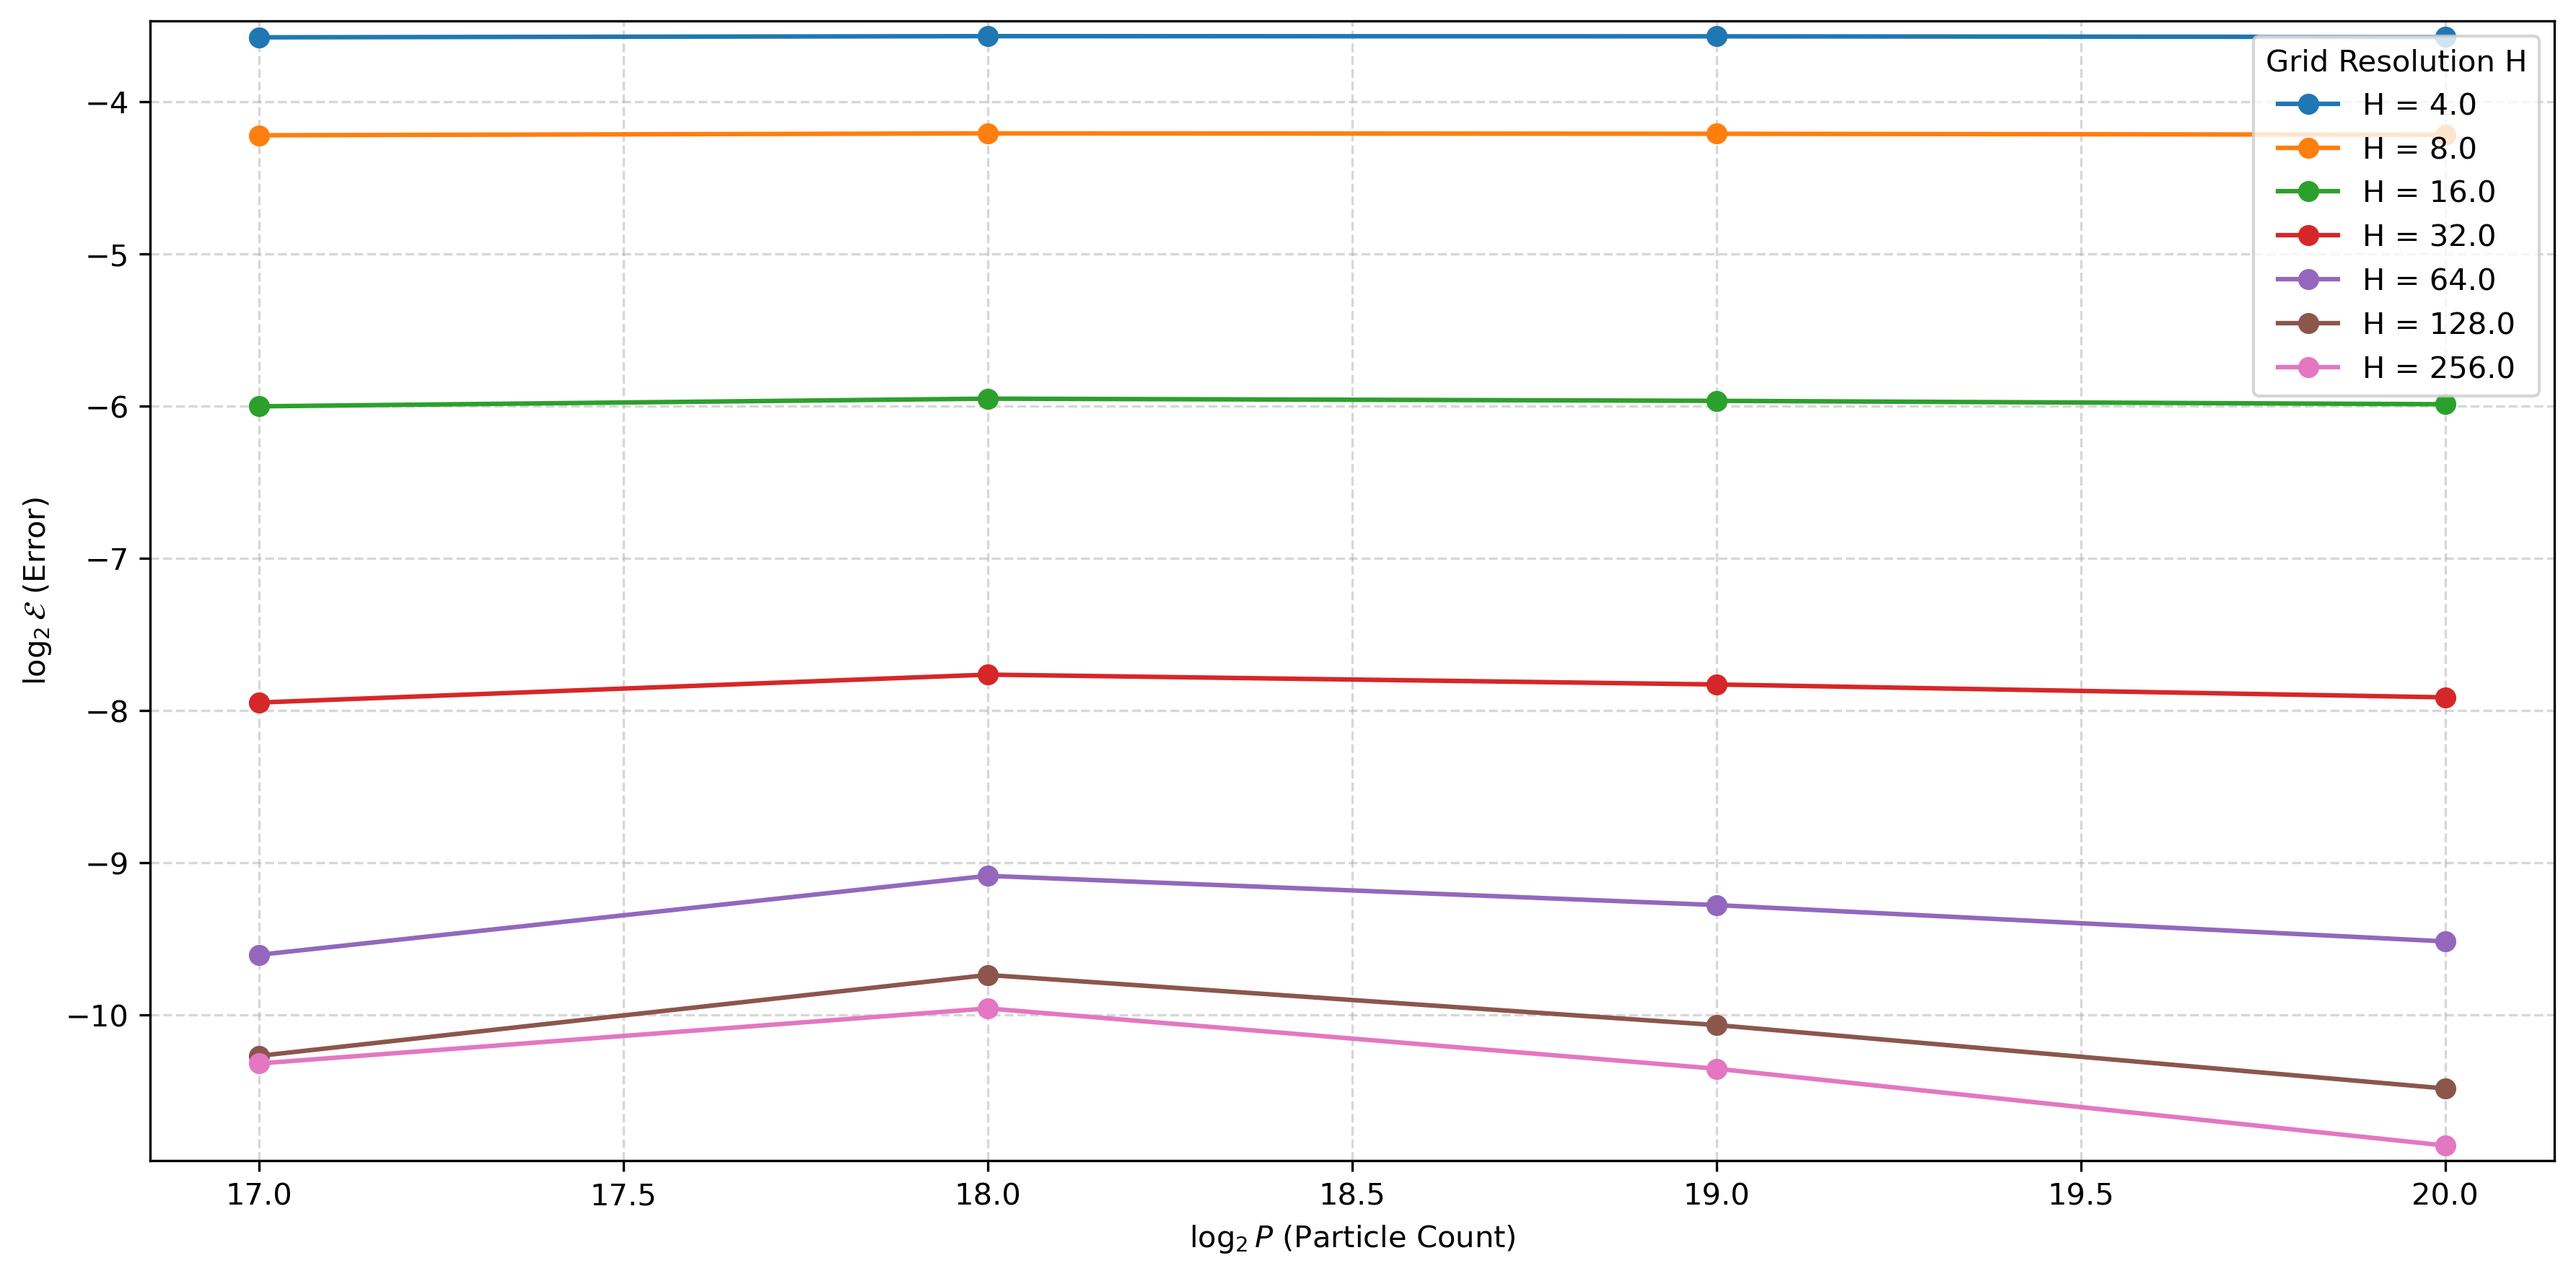

In [9]:
data_sizes = sorted(set(x[0] for x in unique_results)) 
param_sizes = sorted(set(x[1] for x in unique_results)) 

performance_dict = {param: [] for param in param_sizes}

for data_size in data_sizes:
    for param in param_sizes:
        performances = [x[2] for x in unique_results if x[0] == data_size and x[1] == param]
        if performances:
            average_performance = np.mean(performances)
            performance_dict[param].append((data_size, average_performance))

plt.figure(figsize=(12, 6))
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = False
for param, values in performance_dict.items():
    data_sizes, performances = zip(*values)  
    log_data_sizes = np.log2(data_sizes)
    log_performances = np.log2(performances)
    
    plt.plot(log_data_sizes, log_performances, 
            marker='o', 
            label=f'H = {param}')


plt.xlabel(r'$\log_2 P$ (Particle Count)') 
plt.ylabel(r'$\log_2 \mathcal{E}$ (Error)') 

# plt.title('') 

plt.legend(title='Grid Resolution H', loc='upper right') 

max_log_performance = max(np.log2(p) for param in performance_dict for _, p in performance_dict[param])
min_log_performance = min(np.log2(p) for param in performance_dict for _, p in performance_dict[param])
plt.ylim(min_log_performance - 0.1, max_log_performance + 0.1)

plt.grid(True, linestyle='--', alpha=0.5) 
plt.tight_layout()

plt.savefig('convergence_4_4.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()